#### Latest Takt Time Prediction Models
- replaced PIC with ASSY TYPE skills from Engineering Skills Matrix
- correct benchmark of continuously updated PRODUCT-ASSY TYPE and Task mean instead of using mean from training set
- implemented KFold cross validation for hyperparameter tuning
- use of 2025 data as validation set

In [20]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import sqlite3
import numpy as np

from sklearn.metrics import root_mean_squared_error, mean_absolute_error,mean_absolute_percentage_error,r2_score

#### Load files
- task-dataset-B.xlsx : historical task completion times
- default_takt.xlsx : default takt times if no historical data
- PIC_skills.xlsx : skill set of the engineers

In [8]:
def melt_default_task(sheet_name):
    df1 = pd.read_excel('default_takt.xlsx', sheet_name=sheet_name)
    df_melted = df1.melt(id_vars='PRODUCT-ASSY TYPE',
                        var_name='Task',
                        value_name='Takt')
    df_melted = df_melted.dropna()
    df_melted['PRODUCT-ASSY TYPE'] = df_melted['PRODUCT-ASSY TYPE'].str.upper()
    df_melted['Task'] = df_melted['Task'].str.upper()
    return df_melted

df_ml = pd.read_excel('task-dataset-B.xlsx')
df_skills = pd.read_excel('PIC_skills_edited.xlsx')

df_ml = df_ml.merge(df_skills,on='PIC',how='left')
df_ml = df_ml.fillna(0)

df_ml['Date'] = pd.to_datetime(df_ml['Date'])
df_melted = melt_default_task('Sheet1')
df_melted2 = melt_default_task('Sheet2')
df_melted3 = melt_default_task('Sheet3')
df_melted4 = melt_default_task('Sheet4')
df_all_melted = pd.concat([df_melted, df_melted2, df_melted3, df_melted4], ignore_index=True)

# Display the combined DataFrame
display(df_all_melted)

,PRODUCT-ASSY TYPE,Task,Takt
0,BGATSOCKETNEWINQUIRY,PN/PIN HOLE COUNT DETAILS,1.0
1,FPSOCKETNEWINQUIRY,PN/PIN HOLE COUNT DETAILS,1.0
2,LGATSOCKETNEWINQUIRY,PN/PIN HOLE COUNT DETAILS,1.0
3,OTQSOCKETNEWINQUIRY,PN/PIN HOLE COUNT DETAILS,1.0
4,QFNSOCKETNEWINQUIRY,PN/PIN HOLE COUNT DETAILS,1.0
...,...,...,...
3653,MOLDSERIESSOCKETPO,ASSY CHECKING,3.0
3654,OFFTHESHELFSOCKETPO,ASSY CHECKING,2.0
3655,AMSOCKETINQUIRY,ASSY CHECKING,8.0
3656,MOLDSERIESSOCKETINQUIRY,ASSY CHECKING,3.0


#### Create custom classes
- DateTimeSeriesSplit : similar to Sklearn TimeSeriesSplit but need to be indexed by date instead of sequence
- BaselineModel : to predict takt time based on average historical completion time, default takt time if no history yet

In [9]:
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin
from sklearn.model_selection import BaseCrossValidator


class DateTimeSeriesSplit(BaseCrossValidator):
    def __init__(self, date_column, n_splits=5, max_train_size=None, gap=0, window_type='expanding'):
        """
        Parameters:
            date_column (str): Name of the datetime column in X.
            n_splits (int): Number of splits.
            max_train_size (int or None): Max size of training window (only used in rolling window).
            gap (int): Number of days to exclude between train and test.
            window_type (str): 'expanding' (default) or 'rolling'
        """
        if window_type not in ['expanding', 'rolling']:
            raise ValueError("window_type must be 'expanding' or 'rolling'")
        self.date_column = date_column
        self.n_splits = n_splits
        self.max_train_size = max_train_size
        self.gap = gap
        self.window_type = window_type

    def split(self, X, y=None, groups=None):
        if self.date_column not in X.columns:
            raise ValueError(f"{self.date_column} not in DataFrame columns")

        X_sorted = X.sort_values(self.date_column).reset_index()
        date_vals = X_sorted[self.date_column].drop_duplicates().values
        n_dates = len(date_vals)
        split_size = n_dates // (self.n_splits + 1)

        for i in range(1, self.n_splits + 1):
            test_start = i * split_size
            test_end = test_start + split_size
            if test_end > n_dates:
                break

            test_dates = date_vals[test_start:test_end]
            test_start_date = test_dates[0]
            test_end_date = test_dates[-1]

            # Test set mask
            test_mask = (
                (X_sorted[self.date_column] >= test_start_date) &
                (X_sorted[self.date_column] <= test_end_date)
            )
            test_indices = X_sorted[test_mask].index.values

            # Training end is before test_start - gap
            train_end_date = test_start_date - np.timedelta64(self.gap, 'D')
            train_mask = X_sorted[self.date_column] < train_end_date
            train_df = X_sorted[train_mask]

            if self.window_type == 'rolling' and self.max_train_size is not None:
                train_df = train_df.tail(self.max_train_size)

            train_indices = train_df.index.values

            yield train_indices, test_indices

    def get_n_splits(self, X=None, y=None, groups=None):
        return self.n_splits



class BaselineModel(BaseEstimator, RegressorMixin):
    def __init__(self, fit_intercept=True, task_history=None, default_takt=None):
        self.fit_intercept = fit_intercept
        self.task_history = task_history
        self.default_takt = default_takt

    def fit(self, X, y=None):
        # Model doesn't learn anything from training data
        return self

    def predict_takt(self, task_details):
        product_assytype = task_details['PRODUCT-ASSY TYPE']
        task_date = task_details['Date']
        task = task_details['Task']

        df_history = self.task_history[
            (self.task_history['PRODUCT-ASSY TYPE'] == product_assytype) & 
            (self.task_history['Date'] < task_date) & 
            (self.task_history['Task'] == task)
        ]

        if len(df_history) > 0:
            return df_history['Total Adj Time Spent'].mean()

        df_default = self.default_takt[
            (self.default_takt['PRODUCT-ASSY TYPE'] == product_assytype) & 
            (self.default_takt['Task'] == task)
        ]

        if len(df_default) > 0:
            return df_default['Takt'].mean()

        return 0  # fallback if no historical or default data

    def predict(self, X):
        return np.array([self.predict_takt(row) for _, row in X.iterrows()])


In [10]:
def add_historical_performance(df_ml, months_lag=6):
    df_ml['Date'] = pd.to_datetime(df_ml['Date'])
    df_ml = df_ml.sort_values('Date').reset_index(drop=True)
    
    # Create a copy to avoid modifying the original directly
    df_stats = df_ml.copy()
    
    # Sort by group and date
    df_stats = df_stats.sort_values(['ID', 'Task', 'PRODUCT-ASSY TYPE', 'Date','PIC'])
    
    # Initialize result columns
    df_stats['jobs_last_6m'] = np.nan
    df_stats['avg_takt_6m'] = np.nan
    df_stats['std_takt_6m'] = np.nan
    
    # Process group by group
    for (id, task, product, pic), group in df_stats.groupby(['ID', 'Task', 'PRODUCT-ASSY TYPE', 'PIC']):
        for idx, row in group.iterrows():
            cutoff_date = row['Date'] - pd.DateOffset(months=months_lag)
            past_rows = group[(group['Date'] < row['Date']) & (group['Date'] >= cutoff_date)]
    
            df_stats.at[idx, 'jobs_last_6m'] = past_rows.shape[0]
            df_stats.at[idx, 'avg_takt_6m'] = past_rows['Total Adj Time Spent'].mean()
            df_stats.at[idx, 'std_takt_6m'] = past_rows['Total Adj Time Spent'].std()
    
    # Merge new features into the main dataset
    df_result = df_ml.merge(
        df_stats[['ID', 'Date','Task', 'PRODUCT-ASSY TYPE', 'PIC', 'jobs_last_6m', 'avg_takt_6m', 'std_takt_6m']],
        on=['ID', 'Date','Task', 'PRODUCT-ASSY TYPE', 'PIC'],
        how='left'
    )
    df_result['no_history_flag'] = df_result['jobs_last_6m'].isna().astype(int)
    
    # Fill NaNs in stats with 0
    df_result['jobs_last_6m'] = df_result['jobs_last_6m'].fillna(0)
    df_result['avg_takt_6m'] = df_result['avg_takt_6m'].fillna(0)
    df_result['std_takt_6m'] = df_result['std_takt_6m'].fillna(0)
    return df_result

#### Establish Baseline
- use average MAE of the different K-Folds
- set hold out set for validation

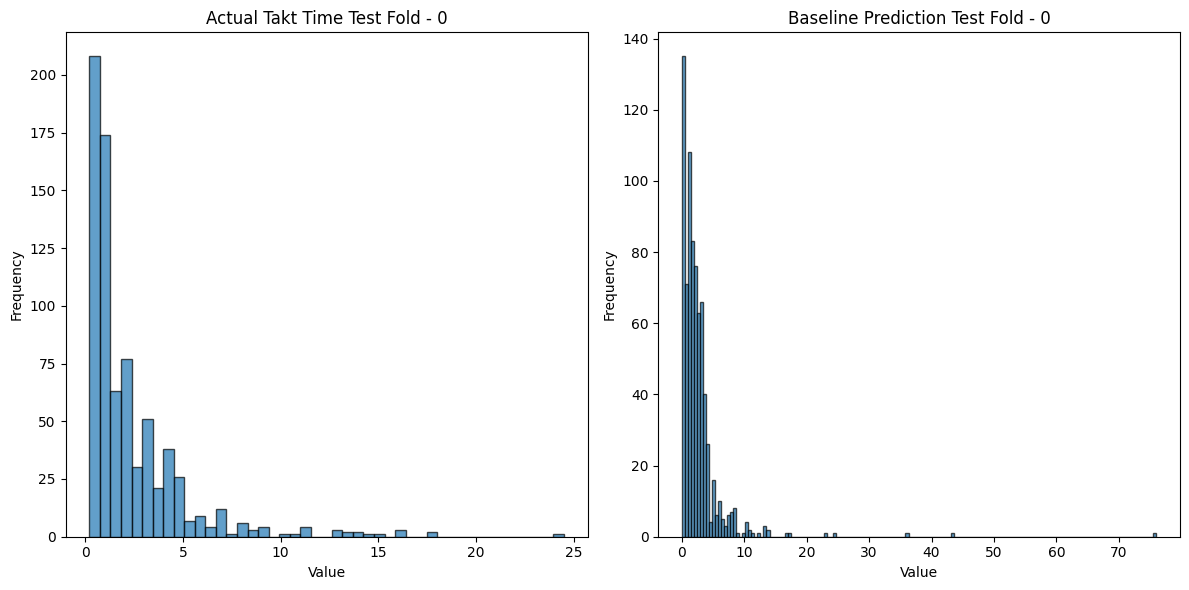

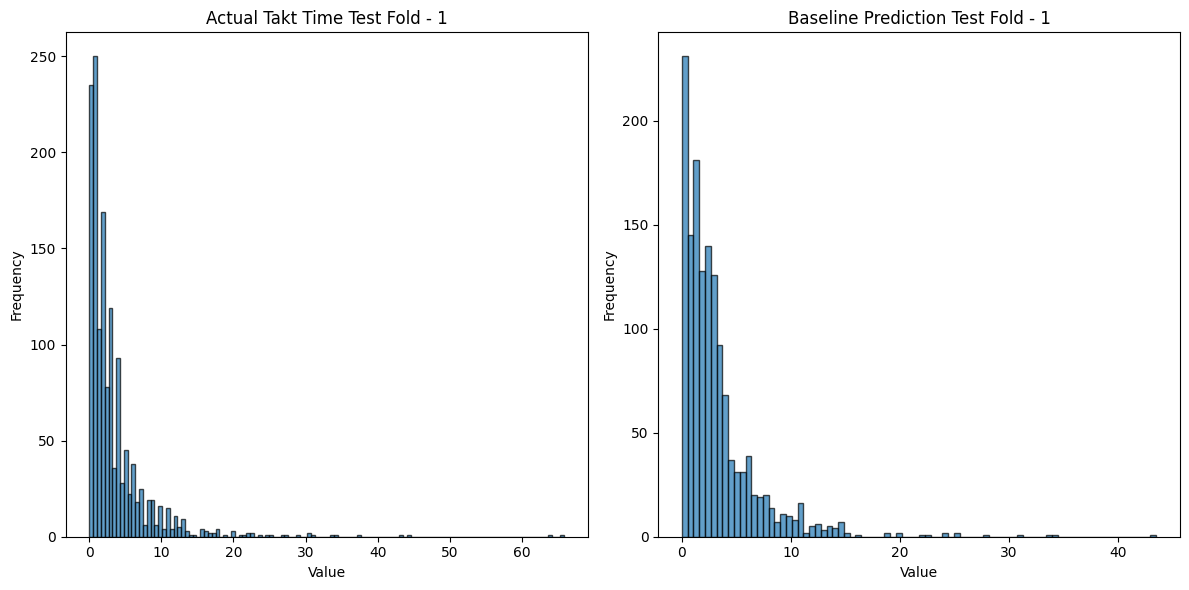

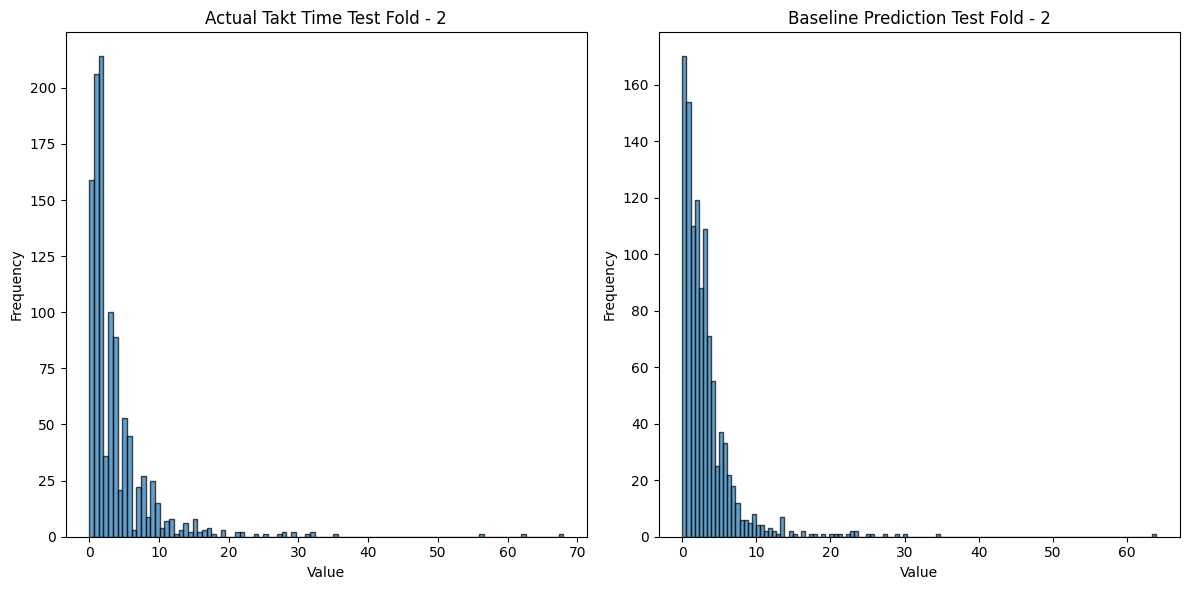

Baseline CV MAE: 2.387316515979903
Baseline CV MAPE: 105400156493960.5
Baseline CV R2: -0.335544288090573
Baseline Validation RMSE:3.684025471629976
Baseline Validation MAE:2.0454510930389627
Baseline Validation MAPE:21783972960994.117
Baseline Validation R2:0.04510745031846608


In [11]:
date_cutoff = '2025-01-01'
n_splits = 3

splitter = DateTimeSeriesSplit(
    date_column="Date",
    n_splits=n_splits
)

ml_results_summary = {}

df_ml_expanded = df_ml.copy() #add_historical_performance(df_ml,12)

baselineModel = BaselineModel(task_history=df_ml_expanded, default_takt=df_all_melted)
baseline_rmse = []
baseline_mape = []
baseline_r2 = []

def plot_baseline_distribution(y_actual, y_prediction, actual_title, prediction_title):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.hist(y_actual, bins='auto', edgecolor='black', alpha=0.7)
    plt.title(actual_title)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    
    # Second plot
    plt.subplot(1, 2, 2)
    plt.hist(y_prediction, bins='auto', edgecolor='black', alpha=0.7)
    plt.title(prediction_title)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show() 

df_train = df_ml_expanded[df_ml_expanded['Date']<date_cutoff]
for i, (train_idx, test_idx) in enumerate(splitter.split(df_train)):
    df_test = df_train.iloc[test_idx]
    y_predict = baselineModel.predict(df_test)
    y_actual = df_test['Total Adj Time Spent'].values

    plot_baseline_distribution(y_actual, y_predict,
                               f"Actual Takt Time Test Fold - {i}",
                               f"Baseline Prediction Test Fold - {i}")
    
    baseline_rmse.append(mean_absolute_error(y_actual, y_predict))
    baseline_mape.append(mean_absolute_percentage_error(y_actual, y_predict))
    baseline_r2.append(r2_score(y_actual, y_predict))

cv_rmse = np.mean(baseline_rmse)
cv_mape = np.mean(baseline_mape)
cv_r2 = np.mean(baseline_r2)

print(f'Baseline CV MAE: {cv_rmse}')
print(f'Baseline CV MAPE: {cv_mape}')
print(f'Baseline CV R2: {cv_r2}')


df_test = df_ml_expanded[df_ml_expanded['Date']>=date_cutoff]
y_predict = baselineModel.predict(df_test)
y_actual = df_test['Total Adj Time Spent'].values
rmse = root_mean_squared_error(y_actual, y_predict)
print(f'Baseline Validation RMSE:{rmse}')
mae = mean_absolute_error(y_actual, y_predict)
print(f'Baseline Validation MAE:{mae}')

mape = mean_absolute_percentage_error(y_actual, y_predict)
print(f'Baseline Validation MAPE:{mape}')

r2 = r2_score(y_actual, y_predict) 
print(f'Baseline Validation R2:{r2}')

ml_results_summary['Baseline']= [baselineModel, cv_r2, rmse, mae,mape,r2]

#### LightGBM

In [12]:
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
import optuna
import numpy as np
import shap
import logging

# Dropper class
class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop):
        self.columns_to_drop = columns_to_drop

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.drop(columns=self.columns_to_drop, errors='ignore')
        
def align_categories(df, cat_cols, unknown_label='Unknown'):
    """
    Ensures consistent categories across cat_cols and adds an 'Unknown' category to handle unseen values.
    """
    df_aligned = df.copy()

    for col in cat_cols:
        # Get all unique values (as strings) and add 'Unknown'
        unique_vals = df_aligned[col].astype(str).unique().tolist()
        if unknown_label not in unique_vals:
            unique_vals.append(unknown_label)
        
        # Set category type with unified categories
        df_aligned[col] = df_aligned[col].astype(str).fillna(unknown_label)
        df_aligned[col] = pd.Categorical(df_aligned[col], categories=unique_vals)
    
    return df_aligned

def show_gbmmodel_interpretation(jaguar_model, X_valid_encoded, category_mappings):
    X_display = X_valid_encoded.copy()

    # Replace encoded values with original category names for display only
    for col, mapping in category_mappings.items():
        X_display[col] = X_display[col].map(mapping)

    explainer = shap.TreeExplainer(jaguar_model)
    shap_values = explainer.shap_values(X_valid_encoded)

    shap.summary_plot(shap_values, X_display, plot_type='bar')
    shap.summary_plot(shap_values, X_display)
    shap.initjs()

    shap.force_plot(explainer.expected_value, shap_values[0], X_display.iloc[0], matplotlib=True)

    shap.plots.waterfall(shap.Explanation(
        values=shap_values[0],
        base_values=explainer.expected_value,
        data=X_display.iloc[0],
        feature_names=X_display.columns.tolist()
    ))

    mean_abs_shap = pd.DataFrame({
        'Feature': X_valid_encoded.columns,
        'Mean_Abs_SHAP': np.abs(shap_values).mean(axis=0)
    }).sort_values('Mean_Abs_SHAP', ascending=False)

    display(mean_abs_shap.head(20))

    top_features = mean_abs_shap['Feature'].head(5)
    for feature in top_features:
        shap.dependence_plot(feature, shap_values, X_valid_encoded, display_features=X_display)

def gbm_hyperparameter_tuning(df_ml, target_col, cat_cols,
                              date_cutoff, n_splits=3, gap=0, window_type='expanding',
                              drop_cols=None):
    if drop_cols is None:
        drop_cols = ['Date']


    df = df_ml.sort_values('Date').reset_index(drop=True)
    df_train = df[df['Date'] < date_cutoff].copy()
    df_valid = df[df['Date'] >= date_cutoff].copy()

    df_train = align_categories(df_train, cat_cols)
    df_valid = align_categories(df_valid, cat_cols)

    category_mappings = {}
    for col in cat_cols:
        df_train[col] = df_train[col].astype('category')
        df_valid[col] = df_valid[col].astype('category')
        category_mappings[col] = dict(enumerate(df_train[col].cat.categories))

    for col in cat_cols:
        df_train[col] = df_train[col].cat.codes
        df_valid[col] = df_valid[col].cat.codes

    y_train = df_train[target_col]
    y_valid = df_valid[target_col]
    X_train = df_train.drop(columns=[target_col])
    X_valid = df_valid.drop(columns=[target_col])

    dropper = ColumnDropper(columns_to_drop=drop_cols)
    X_train_dropped = dropper.fit_transform(X_train)
    X_valid_dropped = dropper.transform(X_valid)

    cat_feature_indices = [X_train_dropped.columns.get_loc(col) for col in cat_cols]

    # --- Step 5: Cross-validation splitter ---
    splitter = DateTimeSeriesSplit(
        date_column='Date',
        n_splits=n_splits,
        gap=gap,
        window_type=window_type
    )

    def objective(trial):
        params = {
            'objective': 'regression',
            'boosting_type': 'gbdt',
            'verbosity': -1,
            'random_state': 42,
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
            'num_leaves': trial.suggest_int('num_leaves', 20, 300),
            'max_depth': trial.suggest_int('max_depth', 3, 15),
            'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 100),
            'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
            'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
            'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
            'lambda_l1': trial.suggest_float('lambda_l1', 0, 5),
            'lambda_l2': trial.suggest_float('lambda_l2', 0, 5),
        }

        scores = []
        for train_idx, val_idx in splitter.split(df_train):
            X_tr = X_train_dropped.iloc[train_idx]
            y_tr = y_train.iloc[train_idx]
            X_te = X_train_dropped.iloc[val_idx]
            y_te = y_train.iloc[val_idx]

            lgb_train = lgb.Dataset(X_tr, y_tr, categorical_feature=cat_feature_indices)
            lgb_valid = lgb.Dataset(X_te, y_te, categorical_feature=cat_feature_indices, reference=lgb_train)
        
            model = lgb.train(
                params,
                lgb_train,
                num_boost_round=1000,
                valid_sets=[lgb_valid],
                callbacks=[
                    early_stopping(stopping_rounds=20),
                    log_evaluation(0)  # 0 = silent, or use 100 to log every 100 rounds
                ]
            )

            preds = model.predict(X_te)
            scores.append(r2_score(y_te, preds))

        return np.mean(scores)

    
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=50, show_progress_bar=False)
    
    print("Best parameters:", study.best_params)
    print("Best CV R2:", study.best_value)
    cv_r2 = study.best_value

    best_trial = study.best_trial
    best_params = best_trial.params
    
    lgb_train = lgb.Dataset(X_train_dropped, y_train, categorical_feature=cat_feature_indices)
    lgb_valid = lgb.Dataset(X_valid_dropped, y_valid, categorical_feature=cat_feature_indices, reference=lgb_train)
    
    best_model = lgb.train(
        best_params,
        lgb_train,
        num_boost_round=1000,
        valid_sets=[lgb_valid],
        callbacks=[
            lgb.early_stopping(stopping_rounds=20),
            lgb.log_evaluation(0)
        ]
    )
    y_pred = best_model.predict(X_valid_dropped)
    rmse = root_mean_squared_error(y_valid, y_pred)
    print("Validation RMSE:", rmse)

    mae = mean_absolute_error(y_valid, y_pred)
    print("Validation MAE:", mae)

    mape = mean_absolute_percentage_error(y_valid, y_pred)
    print("Validation MAPE:", mape)

    r2 = r2_score(y_valid, y_pred)
    print("Validation R2:", r2)   
    
    show_gbmmodel_interpretation(best_model, X_valid_dropped, category_mappings)
    return best_model, cv_r2, rmse, mae, mape, r2

[I 2025-05-24 16:24:04,323] A new study created in memory with name: no-name-55861c70-d29f-43fc-98c5-b6786a09caae
[I 2025-05-24 16:24:04,553] Trial 0 finished with value: 0.2108317018008803 and parameters: {'learning_rate': 0.1326116390383297, 'num_leaves': 205, 'max_depth': 8, 'min_data_in_leaf': 61, 'feature_fraction': 0.697122933944313, 'bagging_fraction': 0.6350760621093279, 'bagging_freq': 4, 'lambda_l1': 1.4411806311185138, 'lambda_l2': 2.6306830200422358}. Best is trial 0 with value: 0.2108317018008803.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[60]	valid_0's l2: 32.7622
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[4]	valid_0's l2: 15.6523
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[28]	valid_0's l2: 9.78931
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[105]	valid_0's l2: 30.5213
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[21]	valid_0's l2: 14.3945


[I 2025-05-24 16:24:04,707] Trial 1 finished with value: 0.26632736740772284 and parameters: {'learning_rate': 0.09748931149721791, 'num_leaves': 197, 'max_depth': 7, 'min_data_in_leaf': 45, 'feature_fraction': 0.698544726227728, 'bagging_fraction': 0.5108841338834282, 'bagging_freq': 7, 'lambda_l1': 4.836653820519111, 'lambda_l2': 0.8335566739283895}. Best is trial 1 with value: 0.26632736740772284.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[48]	valid_0's l2: 9.25104
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[147]	valid_0's l2: 31.7855
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[11]	valid_0's l2: 14.5332
Training until validation scores don't improve for 20 rounds


[I 2025-05-24 16:24:04,880] Trial 2 finished with value: 0.24766826786126417 and parameters: {'learning_rate': 0.05709295561640114, 'num_leaves': 97, 'max_depth': 5, 'min_data_in_leaf': 42, 'feature_fraction': 0.6690661837514684, 'bagging_fraction': 0.5875600671693255, 'bagging_freq': 3, 'lambda_l1': 0.0368222603501811, 'lambda_l2': 2.4545011894934827}. Best is trial 1 with value: 0.26632736740772284.
[I 2025-05-24 16:24:05,042] Trial 3 finished with value: 0.2426177606108786 and parameters: {'learning_rate': 0.15851418309910928, 'num_leaves': 117, 'max_depth': 10, 'min_data_in_leaf': 99, 'feature_fraction': 0.9348714185251602, 'bagging_fraction': 0.9730175617657835, 'bagging_freq': 2, 'lambda_l1': 2.390239007780819, 'lambda_l2': 2.1184709821587266}. Best is trial 1 with value: 0.26632736740772284.


Early stopping, best iteration is:
[94]	valid_0's l2: 9.54563
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[58]	valid_0's l2: 33.7047
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[6]	valid_0's l2: 14.1397
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[59]	valid_0's l2: 9.47816
Training until validation scores don't improve for 20 rounds


[I 2025-05-24 16:24:05,192] Trial 4 finished with value: 0.2525500705365377 and parameters: {'learning_rate': 0.16226981722102377, 'num_leaves': 64, 'max_depth': 12, 'min_data_in_leaf': 11, 'feature_fraction': 0.7606001109354441, 'bagging_fraction': 0.8517090127664, 'bagging_freq': 5, 'lambda_l1': 4.173452172322511, 'lambda_l2': 1.2378299900622158}. Best is trial 1 with value: 0.26632736740772284.


Early stopping, best iteration is:
[23]	valid_0's l2: 31.7576
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[7]	valid_0's l2: 14.0236
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[15]	valid_0's l2: 9.8758
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[79]	valid_0's l2: 32.6205
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[22]	valid_0's l2: 15.1803


[I 2025-05-24 16:24:05,344] Trial 5 finished with value: 0.2304676832611687 and parameters: {'learning_rate': 0.1933202010907734, 'num_leaves': 86, 'max_depth': 5, 'min_data_in_leaf': 67, 'feature_fraction': 0.9058479829561286, 'bagging_fraction': 0.7630771829349843, 'bagging_freq': 6, 'lambda_l1': 3.934906095560154, 'lambda_l2': 0.03979924425074999}. Best is trial 1 with value: 0.26632736740772284.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[43]	valid_0's l2: 9.36961
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[594]	valid_0's l2: 32.5233
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[92]	valid_0's l2: 14.2307
Training until validation scores don't improve for 20 rounds


[I 2025-05-24 16:24:06,029] Trial 6 finished with value: 0.24804164539921003 and parameters: {'learning_rate': 0.01546130618214112, 'num_leaves': 28, 'max_depth': 9, 'min_data_in_leaf': 64, 'feature_fraction': 0.7400230439537858, 'bagging_fraction': 0.6858969727475109, 'bagging_freq': 3, 'lambda_l1': 0.6289494607395735, 'lambda_l2': 4.95335323637453}. Best is trial 1 with value: 0.26632736740772284.


Early stopping, best iteration is:
[294]	valid_0's l2: 9.57015
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[165]	valid_0's l2: 32.6743
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[29]	valid_0's l2: 14.4229


[I 2025-05-24 16:24:06,295] Trial 7 finished with value: 0.2423552512854437 and parameters: {'learning_rate': 0.039227303441987355, 'num_leaves': 79, 'max_depth': 15, 'min_data_in_leaf': 49, 'feature_fraction': 0.9705464700581492, 'bagging_fraction': 0.6237406809675228, 'bagging_freq': 3, 'lambda_l1': 2.0250272345914864, 'lambda_l2': 1.3872059421636789}. Best is trial 1 with value: 0.26632736740772284.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[73]	valid_0's l2: 9.58597
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[89]	valid_0's l2: 32.3283
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[16]	valid_0's l2: 14.0579
Training until validation scores don't improve for 20 rounds


[I 2025-05-24 16:24:06,450] Trial 8 finished with value: 0.2594121394589248 and parameters: {'learning_rate': 0.16432271300448034, 'num_leaves': 75, 'max_depth': 9, 'min_data_in_leaf': 85, 'feature_fraction': 0.6279126925353864, 'bagging_fraction': 0.6186990825398464, 'bagging_freq': 6, 'lambda_l1': 1.5733660286800015, 'lambda_l2': 1.1842686306371264}. Best is trial 1 with value: 0.26632736740772284.


Early stopping, best iteration is:
[58]	valid_0's l2: 9.26004
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[105]	valid_0's l2: 31.93
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[16]	valid_0's l2: 14.6271
Training until validation scores don't improve for 20 rounds


[I 2025-05-24 16:24:06,659] Trial 9 finished with value: 0.24844181939226576 and parameters: {'learning_rate': 0.051390849481382214, 'num_leaves': 158, 'max_depth': 11, 'min_data_in_leaf': 45, 'feature_fraction': 0.9996956084839292, 'bagging_fraction': 0.6510872346938557, 'bagging_freq': 7, 'lambda_l1': 2.716759343043809, 'lambda_l2': 1.8553878451511614}. Best is trial 1 with value: 0.26632736740772284.


Early stopping, best iteration is:
[52]	valid_0's l2: 9.34387
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[130]	valid_0's l2: 29.8868
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[10]	valid_0's l2: 14.32
Training until validation scores don't improve for 20 rounds


[I 2025-05-24 16:24:06,892] Trial 10 finished with value: 0.26193948513712856 and parameters: {'learning_rate': 0.09293508423451599, 'num_leaves': 300, 'max_depth': 4, 'min_data_in_leaf': 17, 'feature_fraction': 0.5326555335497114, 'bagging_fraction': 0.535830725645627, 'bagging_freq': 1, 'lambda_l1': 4.835022765215535, 'lambda_l2': 0.018810446681554627}. Best is trial 1 with value: 0.26632736740772284.


Early stopping, best iteration is:
[37]	valid_0's l2: 9.81081
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[119]	valid_0's l2: 29.4996
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[10]	valid_0's l2: 14.165
Training until validation scores don't improve for 20 rounds


[I 2025-05-24 16:24:07,096] Trial 11 finished with value: 0.26590369077865755 and parameters: {'learning_rate': 0.0953220565568435, 'num_leaves': 299, 'max_depth': 3, 'min_data_in_leaf': 16, 'feature_fraction': 0.5100410934305782, 'bagging_fraction': 0.5155174961869201, 'bagging_freq': 1, 'lambda_l1': 4.9666738419602545, 'lambda_l2': 0.20241786897694958}. Best is trial 1 with value: 0.26632736740772284.


Early stopping, best iteration is:
[37]	valid_0's l2: 9.93548
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[105]	valid_0's l2: 30.132
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[10]	valid_0's l2: 14.2247
Training until validation scores don't improve for 20 rounds


[I 2025-05-24 16:24:07,322] Trial 12 finished with value: 0.2668494515066178 and parameters: {'learning_rate': 0.09639481039073784, 'num_leaves': 297, 'max_depth': 3, 'min_data_in_leaf': 29, 'feature_fraction': 0.5449014869099474, 'bagging_fraction': 0.5058235101004915, 'bagging_freq': 1, 'lambda_l1': 4.935493572576603, 'lambda_l2': 0.6330550376829214}. Best is trial 12 with value: 0.2668494515066178.


Early stopping, best iteration is:
[111]	valid_0's l2: 9.56881
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[41]	valid_0's l2: 31.7804
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[6]	valid_0's l2: 14.4983
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[48]	valid_0's l2: 8.8725


[I 2025-05-24 16:24:07,514] Trial 13 finished with value: 0.2616544096341607 and parameters: {'learning_rate': 0.1173074794287717, 'num_leaves': 232, 'max_depth': 7, 'min_data_in_leaf': 31, 'feature_fraction': 0.8145987908142875, 'bagging_fraction': 0.5003619864277137, 'bagging_freq': 7, 'lambda_l1': 3.404937094854855, 'lambda_l2': 3.2387177358798382}. Best is trial 12 with value: 0.2668494515066178.
[I 2025-05-24 16:24:07,738] Trial 14 finished with value: 0.25507975344191963 and parameters: {'learning_rate': 0.07807883673260757, 'num_leaves': 250, 'max_depth': 6, 'min_data_in_leaf': 32, 'feature_fraction': 0.5706622038650774, 'bagging_fraction': 0.7536341908344131, 'bagging_freq': 5, 'lambda_l1': 4.2324400030302005, 'lambda_l2': 0.7880292422319315}. Best is trial 12 with value: 0.2668494515066178.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[100]	valid_0's l2: 32.7172
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[19]	valid_0's l2: 13.8744
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[36]	valid_0's l2: 9.53103


[I 2025-05-24 16:24:07,918] Trial 15 finished with value: 0.26035857116980154 and parameters: {'learning_rate': 0.11506405861177241, 'num_leaves': 156, 'max_depth': 3, 'min_data_in_leaf': 36, 'feature_fraction': 0.5935858869896321, 'bagging_fraction': 0.8365080355889728, 'bagging_freq': 2, 'lambda_l1': 3.345581959259932, 'lambda_l2': 3.47911195298388}. Best is trial 12 with value: 0.2668494515066178.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[54]	valid_0's l2: 32.1532
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[6]	valid_0's l2: 13.5068
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[40]	valid_0's l2: 9.89602
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[60]	valid_0's l2: 31.8292
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[11]	valid_0's l2: 14.448
Training until validation scores don't improve for 20 rounds


[I 2025-05-24 16:24:08,316] Trial 16 finished with value: 0.2531750330735456 and parameters: {'learning_rate': 0.07363909584946064, 'num_leaves': 200, 'max_depth': 13, 'min_data_in_leaf': 25, 'feature_fraction': 0.8382062451604726, 'bagging_fraction': 0.5659493430604584, 'bagging_freq': 4, 'lambda_l1': 4.472446089905716, 'lambda_l2': 0.7675902882498828}. Best is trial 12 with value: 0.2668494515066178.


Early stopping, best iteration is:
[64]	valid_0's l2: 9.34213
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[90]	valid_0's l2: 32.0921
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[17]	valid_0's l2: 14.1809


[I 2025-05-24 16:24:08,610] Trial 17 finished with value: 0.25718874096934713 and parameters: {'learning_rate': 0.1357683869010385, 'num_leaves': 259, 'max_depth': 7, 'min_data_in_leaf': 76, 'feature_fraction': 0.6130352271221413, 'bagging_fraction': 0.7058308643473965, 'bagging_freq': 6, 'lambda_l1': 3.451976737189203, 'lambda_l2': 0.637457334870197}. Best is trial 12 with value: 0.2668494515066178.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[60]	valid_0's l2: 9.3304
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[78]	valid_0's l2: 33.5566
Training until validation scores don't improve for 20 rounds


[I 2025-05-24 16:24:08,872] Trial 18 finished with value: 0.23630018322787097 and parameters: {'learning_rate': 0.08986269559022525, 'num_leaves': 198, 'max_depth': 5, 'min_data_in_leaf': 53, 'feature_fraction': 0.6738162904407818, 'bagging_fraction': 0.9619869399921455, 'bagging_freq': 5, 'lambda_l1': 3.7723465270588834, 'lambda_l2': 4.399196427626862}. Best is trial 12 with value: 0.2668494515066178.


Early stopping, best iteration is:
[37]	valid_0's l2: 14.365
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[75]	valid_0's l2: 9.60839
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[55]	valid_0's l2: 31.8429


[I 2025-05-24 16:24:09,127] Trial 19 finished with value: 0.250883377207386 and parameters: {'learning_rate': 0.1371748368383598, 'num_leaves': 271, 'max_depth': 7, 'min_data_in_leaf': 25, 'feature_fraction': 0.552672488714468, 'bagging_fraction': 0.5803868505611065, 'bagging_freq': 2, 'lambda_l1': 2.8932076129953948, 'lambda_l2': 1.6916407617526779}. Best is trial 12 with value: 0.2668494515066178.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[5]	valid_0's l2: 14.5047
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[54]	valid_0's l2: 9.39044
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[265]	valid_0's l2: 32.7538
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[84]	valid_0's l2: 13.6454
Training until validation scores don't improve for 20 rounds


[I 2025-05-24 16:24:09,424] Trial 20 finished with value: 0.25946986347119455 and parameters: {'learning_rate': 0.022471833372797526, 'num_leaves': 141, 'max_depth': 3, 'min_data_in_leaf': 42, 'feature_fraction': 0.7892198904209906, 'bagging_fraction': 0.8133357689916138, 'bagging_freq': 1, 'lambda_l1': 4.5706304939091575, 'lambda_l2': 0.5709096094410607}. Best is trial 12 with value: 0.2668494515066178.


Early stopping, best iteration is:
[162]	valid_0's l2: 9.54768
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[55]	valid_0's l2: 30.4316
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[10]	valid_0's l2: 14.102
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[42]	valid_0's l2: 9.94324


[I 2025-05-24 16:24:09,604] Trial 21 finished with value: 0.2598582594318898 and parameters: {'learning_rate': 0.10484892717208943, 'num_leaves': 298, 'max_depth': 3, 'min_data_in_leaf': 16, 'feature_fraction': 0.5086734002268675, 'bagging_fraction': 0.5097200110274206, 'bagging_freq': 1, 'lambda_l1': 4.944280684543995, 'lambda_l2': 0.4193555216471564}. Best is trial 12 with value: 0.2668494515066178.
[I 2025-05-24 16:24:09,827] Trial 22 finished with value: 0.2587305663240536 and parameters: {'learning_rate': 0.08463938693464154, 'num_leaves': 228, 'max_depth': 4, 'min_data_in_leaf': 23, 'feature_fraction': 0.5067603707521449, 'bagging_fraction': 0.5459393233216585, 'bagging_freq': 2, 'lambda_l1': 4.81254395516642, 'lambda_l2': 1.0801794613502045}. Best is trial 12 with value: 0.2668494515066178.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[76]	valid_0's l2: 31.2308
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[14]	valid_0's l2: 14.1148
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[69]	valid_0's l2: 9.66831
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[197]	valid_0's l2: 30.7492
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[23]	valid_0's l2: 14.4824
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[117]	valid_0's l2: 9.66886


[I 2025-05-24 16:24:10,109] Trial 23 finished with value: 0.2544455746811765 and parameters: {'learning_rate': 0.06030530209358617, 'num_leaves': 278, 'max_depth': 4, 'min_data_in_leaf': 35, 'feature_fraction': 0.5670150539176164, 'bagging_fraction': 0.5319357807318899, 'bagging_freq': 1, 'lambda_l1': 4.985108509028005, 'lambda_l2': 0.36958694987703367}. Best is trial 12 with value: 0.2668494515066178.
[I 2025-05-24 16:24:10,330] Trial 24 finished with value: 0.2636165685117214 and parameters: {'learning_rate': 0.1038526297325243, 'num_leaves': 182, 'max_depth': 6, 'min_data_in_leaf': 19, 'feature_fraction': 0.7161215990651646, 'bagging_fraction': 0.5936566702505137, 'bagging_freq': 3, 'lambda_l1': 4.36232120489859, 'lambda_l2': 0.05914176598002591}. Best is trial 12 with value: 0.2668494515066178.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[51]	valid_0's l2: 31.3745
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[10]	valid_0's l2: 13.731
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[39]	valid_0's l2: 9.78974


[I 2025-05-24 16:24:10,556] Trial 25 finished with value: 0.24643804514169987 and parameters: {'learning_rate': 0.1176522866340544, 'num_leaves': 233, 'max_depth': 6, 'min_data_in_leaf': 56, 'feature_fraction': 0.6481452884322856, 'bagging_fraction': 0.9102419083009254, 'bagging_freq': 4, 'lambda_l1': 3.846601844917682, 'lambda_l2': 1.5237185769522517}. Best is trial 12 with value: 0.2668494515066178.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[72]	valid_0's l2: 34.0865
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[7]	valid_0's l2: 13.8343
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[44]	valid_0's l2: 9.47172


[I 2025-05-24 16:24:10,758] Trial 26 finished with value: 0.26667846278301766 and parameters: {'learning_rate': 0.06997256502812893, 'num_leaves': 279, 'max_depth': 3, 'min_data_in_leaf': 11, 'feature_fraction': 0.8677906552868873, 'bagging_fraction': 0.5147999673774283, 'bagging_freq': 2, 'lambda_l1': 4.540808102733589, 'lambda_l2': 0.9836653094725467}. Best is trial 12 with value: 0.2668494515066178.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[92]	valid_0's l2: 29.9962
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[22]	valid_0's l2: 14.1726
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[55]	valid_0's l2: 9.68965
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[54]	valid_0's l2: 32.0913
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[19]	valid_0's l2: 13.3443
Training until validation scores don't improve for 20 rounds


[I 2025-05-24 16:24:11,159] Trial 27 finished with value: 0.2735682625963434 and parameters: {'learning_rate': 0.06766876041128682, 'num_leaves': 275, 'max_depth': 8, 'min_data_in_leaf': 11, 'feature_fraction': 0.8737926587273218, 'bagging_fraction': 0.6803213956339588, 'bagging_freq': 2, 'lambda_l1': 4.4481798606453005, 'lambda_l2': 0.9940257512307946}. Best is trial 27 with value: 0.2735682625963434.


Early stopping, best iteration is:
[56]	valid_0's l2: 9.42748
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[118]	valid_0's l2: 31.3551
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[40]	valid_0's l2: 13.5513
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[65]	valid_0's l2: 9.8007


[I 2025-05-24 16:24:11,594] Trial 28 finished with value: 0.2674769344611215 and parameters: {'learning_rate': 0.03818938265423082, 'num_leaves': 274, 'max_depth': 15, 'min_data_in_leaf': 11, 'feature_fraction': 0.8683149413981469, 'bagging_fraction': 0.6920752635911124, 'bagging_freq': 2, 'lambda_l1': 3.979037049424725, 'lambda_l2': 2.450569825498758}. Best is trial 27 with value: 0.2735682625963434.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[120]	valid_0's l2: 31.2081
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[48]	valid_0's l2: 13.2406


[I 2025-05-24 16:24:12,089] Trial 29 finished with value: 0.28099794187275146 and parameters: {'learning_rate': 0.03580178735227483, 'num_leaves': 254, 'max_depth': 15, 'min_data_in_leaf': 11, 'feature_fraction': 0.8860328845537556, 'bagging_fraction': 0.6923390798255206, 'bagging_freq': 2, 'lambda_l1': 3.0756205057013974, 'lambda_l2': 2.9933189321155536}. Best is trial 29 with value: 0.28099794187275146.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[66]	valid_0's l2: 9.51545
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[147]	valid_0's l2: 31.3024
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[51]	valid_0's l2: 13.3094


[I 2025-05-24 16:24:12,556] Trial 30 finished with value: 0.2777937639004365 and parameters: {'learning_rate': 0.03566629000719816, 'num_leaves': 249, 'max_depth': 15, 'min_data_in_leaf': 10, 'feature_fraction': 0.8830254001559106, 'bagging_fraction': 0.7083060208532065, 'bagging_freq': 3, 'lambda_l1': 3.0421354262430578, 'lambda_l2': 3.1335275398513014}. Best is trial 29 with value: 0.28099794187275146.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[60]	valid_0's l2: 9.5648
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[147]	valid_0's l2: 30.9666
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[51]	valid_0's l2: 13.1232
Training until validation scores don't improve for 20 rounds


[I 2025-05-24 16:24:13,415] Trial 31 finished with value: 0.2877791593439121 and parameters: {'learning_rate': 0.03547257539312328, 'num_leaves': 249, 'max_depth': 15, 'min_data_in_leaf': 10, 'feature_fraction': 0.8837327588933493, 'bagging_fraction': 0.6865480542096106, 'bagging_freq': 3, 'lambda_l1': 3.093217447523278, 'lambda_l2': 3.128374267807498}. Best is trial 31 with value: 0.2877791593439121.


Early stopping, best iteration is:
[82]	valid_0's l2: 9.39633
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[172]	valid_0's l2: 31.6249
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[72]	valid_0's l2: 13.1514
Training until validation scores don't improve for 20 rounds


[I 2025-05-24 16:24:14,177] Trial 32 finished with value: 0.27831667877810623 and parameters: {'learning_rate': 0.03125929125487554, 'num_leaves': 220, 'max_depth': 14, 'min_data_in_leaf': 10, 'feature_fraction': 0.9237717702051881, 'bagging_fraction': 0.7194515465828564, 'bagging_freq': 3, 'lambda_l1': 3.186836927686951, 'lambda_l2': 3.16207136762567}. Best is trial 31 with value: 0.2877791593439121.


Early stopping, best iteration is:
[80]	valid_0's l2: 9.58591
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[147]	valid_0's l2: 32.0499
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[51]	valid_0's l2: 13.6628
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[85]	valid_0's l2: 9.20835


[I 2025-05-24 16:24:14,548] Trial 33 finished with value: 0.27122507484187103 and parameters: {'learning_rate': 0.032630051125176265, 'num_leaves': 217, 'max_depth': 14, 'min_data_in_leaf': 22, 'feature_fraction': 0.9250531512367299, 'bagging_fraction': 0.7278120266933764, 'bagging_freq': 3, 'lambda_l1': 3.0600696437688177, 'lambda_l2': 3.280612338812479}. Best is trial 31 with value: 0.2877791593439121.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[426]	valid_0's l2: 32.3184
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[69]	valid_0's l2: 14.2224
Training until validation scores don't improve for 20 rounds


[I 2025-05-24 16:24:15,585] Trial 34 finished with value: 0.25353213364967525 and parameters: {'learning_rate': 0.010665993949297542, 'num_leaves': 246, 'max_depth': 14, 'min_data_in_leaf': 18, 'feature_fraction': 0.9574743915764465, 'bagging_fraction': 0.7881856125631743, 'bagging_freq': 4, 'lambda_l1': 2.294658793733798, 'lambda_l2': 2.8754473054419645}. Best is trial 31 with value: 0.2877791593439121.


Early stopping, best iteration is:
[220]	valid_0's l2: 9.38064
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[136]	valid_0's l2: 31.2339
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[48]	valid_0's l2: 13.8126
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[74]	valid_0's l2: 9.55161


[I 2025-05-24 16:24:15,956] Trial 35 finished with value: 0.267594204441292 and parameters: {'learning_rate': 0.047538800096183734, 'num_leaves': 185, 'max_depth': 14, 'min_data_in_leaf': 14, 'feature_fraction': 0.835439518589022, 'bagging_fraction': 0.6556460689748955, 'bagging_freq': 3, 'lambda_l1': 2.6200231024686333, 'lambda_l2': 3.812037273620758}. Best is trial 31 with value: 0.2877791593439121.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[196]	valid_0's l2: 32.0881
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[40]	valid_0's l2: 14.3556
Training until validation scores don't improve for 20 rounds


[I 2025-05-24 16:24:16,291] Trial 36 finished with value: 0.2566468662989013 and parameters: {'learning_rate': 0.030306340039763256, 'num_leaves': 218, 'max_depth': 13, 'min_data_in_leaf': 26, 'feature_fraction': 0.895684052170921, 'bagging_fraction': 0.7210750360136259, 'bagging_freq': 4, 'lambda_l1': 3.1366302537268846, 'lambda_l2': 2.8339062193689712}. Best is trial 31 with value: 0.2877791593439121.


Early stopping, best iteration is:
[80]	valid_0's l2: 9.16477
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[114]	valid_0's l2: 31.667
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[21]	valid_0's l2: 14.0763
Training until validation scores don't improve for 20 rounds


[I 2025-05-24 16:24:16,573] Trial 37 finished with value: 0.25882718273367594 and parameters: {'learning_rate': 0.04692631063120779, 'num_leaves': 251, 'max_depth': 15, 'min_data_in_leaf': 19, 'feature_fraction': 0.9396574958367931, 'bagging_fraction': 0.7796423230673082, 'bagging_freq': 3, 'lambda_l1': 1.9070955890192005, 'lambda_l2': 4.019368291684028}. Best is trial 31 with value: 0.2877791593439121.


Early stopping, best iteration is:
[44]	valid_0's l2: 9.53272
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[405]	valid_0's l2: 33.846
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[60]	valid_0's l2: 13.784
Training until validation scores don't improve for 20 rounds


[I 2025-05-24 16:24:16,935] Trial 38 finished with value: 0.24389501389901846 and parameters: {'learning_rate': 0.022279032114347418, 'num_leaves': 183, 'max_depth': 12, 'min_data_in_leaf': 97, 'feature_fraction': 0.901423499290082, 'bagging_fraction': 0.7400436928034212, 'bagging_freq': 3, 'lambda_l1': 3.617901616262965, 'lambda_l2': 2.176750199399184}. Best is trial 31 with value: 0.2877791593439121.


Early stopping, best iteration is:
[193]	valid_0's l2: 9.75336
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[80]	valid_0's l2: 31.9954
Training until validation scores don't improve for 20 rounds


[I 2025-05-24 16:24:17,270] Trial 39 finished with value: 0.2772272637570832 and parameters: {'learning_rate': 0.05935825657777637, 'num_leaves': 214, 'max_depth': 13, 'min_data_in_leaf': 10, 'feature_fraction': 0.7866247946889661, 'bagging_fraction': 0.6693209480621969, 'bagging_freq': 4, 'lambda_l1': 2.235909546077509, 'lambda_l2': 2.928799144572843}. Best is trial 31 with value: 0.2877791593439121.


Early stopping, best iteration is:
[40]	valid_0's l2: 13.0947
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[46]	valid_0's l2: 9.55727
Training until validation scores don't improve for 20 rounds


[I 2025-05-24 16:24:17,570] Trial 40 finished with value: 0.24202551350481114 and parameters: {'learning_rate': 0.028162583683926067, 'num_leaves': 240, 'max_depth': 15, 'min_data_in_leaf': 38, 'feature_fraction': 0.9798605123911999, 'bagging_fraction': 0.6188071309157124, 'bagging_freq': 3, 'lambda_l1': 0.796625094298717, 'lambda_l2': 3.6105697994024215}. Best is trial 31 with value: 0.2877791593439121.


Early stopping, best iteration is:
[165]	valid_0's l2: 32.6624
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[48]	valid_0's l2: 14.582
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[99]	valid_0's l2: 9.43012
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[99]	valid_0's l2: 31.4052
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[13]	valid_0's l2: 14.4514
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[51]	valid_0's l2: 9.67503


[I 2025-05-24 16:24:17,872] Trial 41 finished with value: 0.24988713565627343 and parameters: {'learning_rate': 0.05833979271738565, 'num_leaves': 215, 'max_depth': 13, 'min_data_in_leaf': 10, 'feature_fraction': 0.7831645634067227, 'bagging_fraction': 0.6498524978140184, 'bagging_freq': 4, 'lambda_l1': 2.325717456460135, 'lambda_l2': 3.0972126865601046}. Best is trial 31 with value: 0.2877791593439121.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[108]	valid_0's l2: 32.0513
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[40]	valid_0's l2: 13.0719
Training until validation scores don't improve for 20 rounds


[I 2025-05-24 16:24:18,173] Trial 42 finished with value: 0.27921330418299056 and parameters: {'learning_rate': 0.04149773240283186, 'num_leaves': 260, 'max_depth': 14, 'min_data_in_leaf': 14, 'feature_fraction': 0.9262984733079557, 'bagging_fraction': 0.6685565384843399, 'bagging_freq': 4, 'lambda_l1': 2.8751192062035456, 'lambda_l2': 2.5533626143654566}. Best is trial 31 with value: 0.2877791593439121.


Early stopping, best iteration is:
[52]	valid_0's l2: 9.45898
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[111]	valid_0's l2: 31.9414
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[40]	valid_0's l2: 12.3965
Training until validation scores don't improve for 20 rounds


[I 2025-05-24 16:24:19,709] Trial 43 finished with value: 0.29439455144310667 and parameters: {'learning_rate': 0.043649624432244225, 'num_leaves': 260, 'max_depth': 14, 'min_data_in_leaf': 15, 'feature_fraction': 0.922530360776425, 'bagging_fraction': 0.7007200092683645, 'bagging_freq': 4, 'lambda_l1': 2.842934848383842, 'lambda_l2': 2.4786125773087773}. Best is trial 43 with value: 0.29439455144310667.


Early stopping, best iteration is:
[40]	valid_0's l2: 9.48098
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[75]	valid_0's l2: 32.5164
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[40]	valid_0's l2: 12.9062
Training until validation scores don't improve for 20 rounds


[I 2025-05-24 16:24:21,452] Trial 44 finished with value: 0.28282169337795987 and parameters: {'learning_rate': 0.04469025211442352, 'num_leaves': 260, 'max_depth': 14, 'min_data_in_leaf': 15, 'feature_fraction': 0.9506516463775404, 'bagging_fraction': 0.7684620632919356, 'bagging_freq': 5, 'lambda_l1': 2.7793152198341224, 'lambda_l2': 2.6059554784529073}. Best is trial 43 with value: 0.29439455144310667.


Early stopping, best iteration is:
[35]	valid_0's l2: 9.27441
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[135]	valid_0's l2: 32.0196
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[40]	valid_0's l2: 13.1633
Training until validation scores don't improve for 20 rounds


[I 2025-05-24 16:24:23,376] Trial 45 finished with value: 0.27583695781197576 and parameters: {'learning_rate': 0.043168058869222405, 'num_leaves': 261, 'max_depth': 12, 'min_data_in_leaf': 19, 'feature_fraction': 0.9519006287451371, 'bagging_fraction': 0.7747922533201815, 'bagging_freq': 5, 'lambda_l1': 2.5813036677055576, 'lambda_l2': 2.567697326428167}. Best is trial 43 with value: 0.29439455144310667.


Early stopping, best iteration is:
[35]	valid_0's l2: 9.54212
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[225]	valid_0's l2: 31.2394
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[50]	valid_0's l2: 14.2173
Training until validation scores don't improve for 20 rounds


[I 2025-05-24 16:24:25,739] Trial 46 finished with value: 0.2647130694918322 and parameters: {'learning_rate': 0.020960360106937845, 'num_leaves': 41, 'max_depth': 11, 'min_data_in_leaf': 15, 'feature_fraction': 0.9848706897437787, 'bagging_fraction': 0.6401530204658457, 'bagging_freq': 5, 'lambda_l1': 2.808188758713714, 'lambda_l2': 2.0755209764833134}. Best is trial 43 with value: 0.29439455144310667.


Early stopping, best iteration is:
[140]	valid_0's l2: 9.24515
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[30]	valid_0's l2: 34.2888
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[8]	valid_0's l2: 13.8844
Training until validation scores don't improve for 20 rounds


[I 2025-05-24 16:24:26,742] Trial 47 finished with value: 0.238767170025366 and parameters: {'learning_rate': 0.19652200786659088, 'num_leaves': 264, 'max_depth': 14, 'min_data_in_leaf': 28, 'feature_fraction': 0.8458003666930674, 'bagging_fraction': 0.8076192252159493, 'bagging_freq': 6, 'lambda_l1': 1.9948090274890353, 'lambda_l2': 2.4051979934165777}. Best is trial 43 with value: 0.29439455144310667.


Early stopping, best iteration is:
[8]	valid_0's l2: 9.72692
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[100]	valid_0's l2: 32.494
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[35]	valid_0's l2: 13.3572
Training until validation scores don't improve for 20 rounds


[I 2025-05-24 16:24:27,721] Trial 48 finished with value: 0.27396981953604593 and parameters: {'learning_rate': 0.051977626732170386, 'num_leaves': 285, 'max_depth': 11, 'min_data_in_leaf': 23, 'feature_fraction': 0.9188852492674731, 'bagging_fraction': 0.7481542110140836, 'bagging_freq': 5, 'lambda_l1': 2.862850756439281, 'lambda_l2': 2.701533680674646}. Best is trial 43 with value: 0.29439455144310667.


Early stopping, best iteration is:
[36]	valid_0's l2: 9.23223
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[204]	valid_0's l2: 33.5249
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[40]	valid_0's l2: 14.0623
Training until validation scores don't improve for 20 rounds


[I 2025-05-24 16:24:29,020] Trial 49 finished with value: 0.24914027119098422 and parameters: {'learning_rate': 0.04328815989990732, 'num_leaves': 238, 'max_depth': 15, 'min_data_in_leaf': 70, 'feature_fraction': 0.9593252592963546, 'bagging_fraction': 0.8606955545045998, 'bagging_freq': 4, 'lambda_l1': 1.802725348260087, 'lambda_l2': 2.179121755246669}. Best is trial 43 with value: 0.29439455144310667.


Early stopping, best iteration is:
[116]	valid_0's l2: 9.30305
Best parameters: {'learning_rate': 0.043649624432244225, 'num_leaves': 260, 'max_depth': 14, 'min_data_in_leaf': 15, 'feature_fraction': 0.922530360776425, 'bagging_fraction': 0.7007200092683645, 'bagging_freq': 4, 'lambda_l1': 2.842934848383842, 'lambda_l2': 2.4786125773087773}
Best CV R2: 0.29439455144310667
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[14]	valid_0's l2: 14.29
Validation RMSE: 3.7802164215304894
Validation MAE: 2.652089416432583
Validation MAPE: 23722662519806.367
Validation R2: -0.005408575310577257


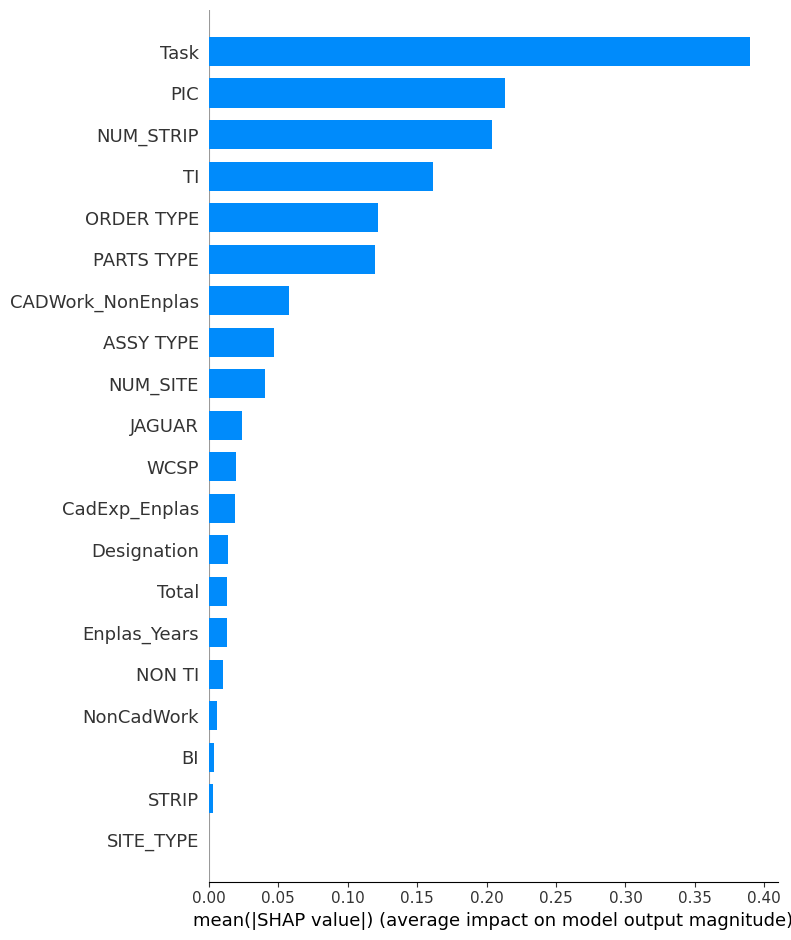

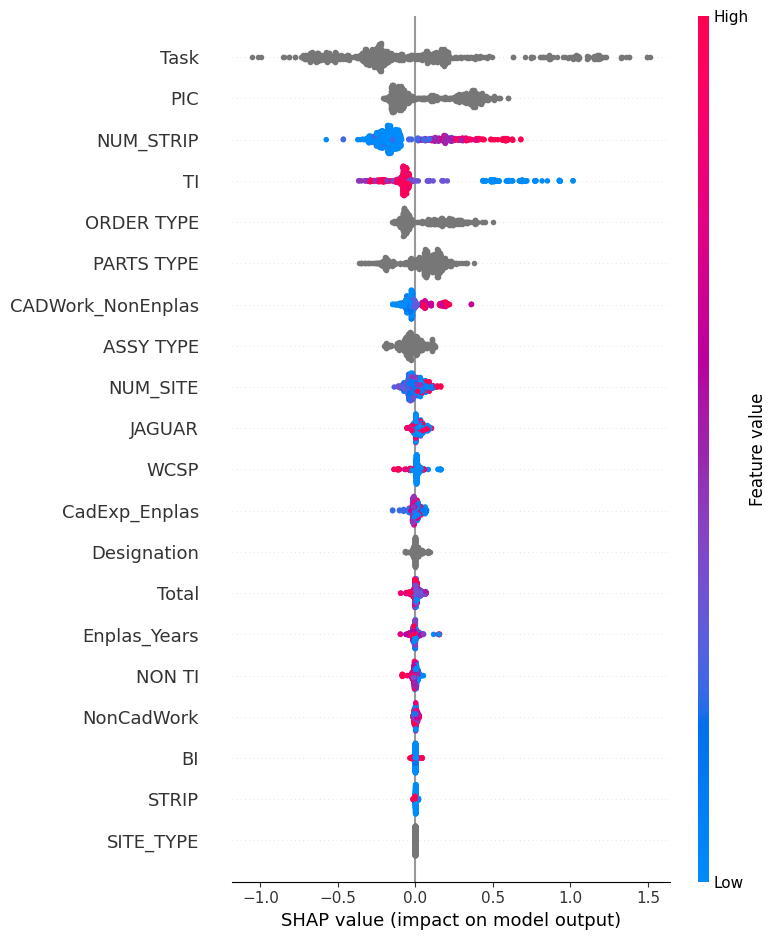

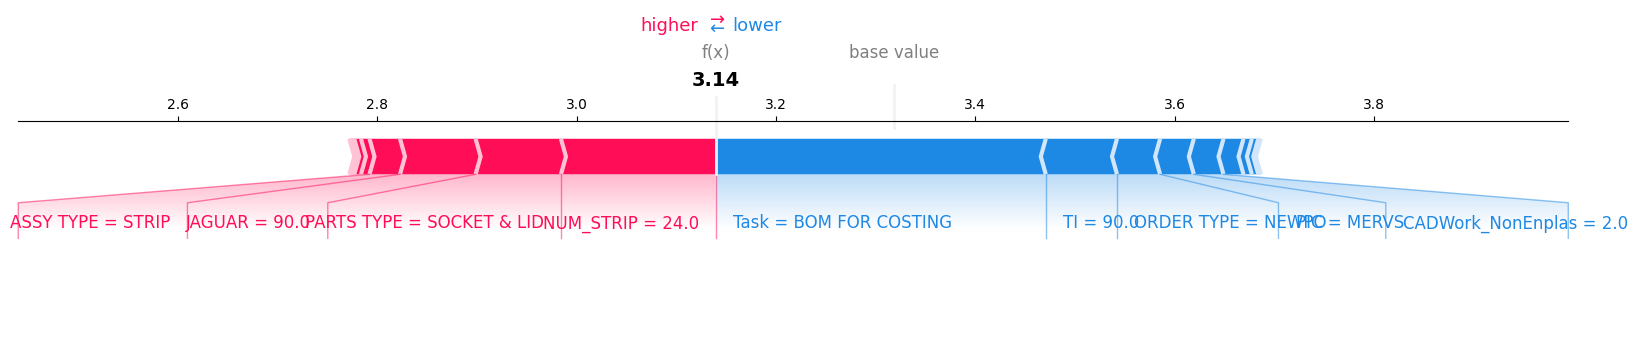

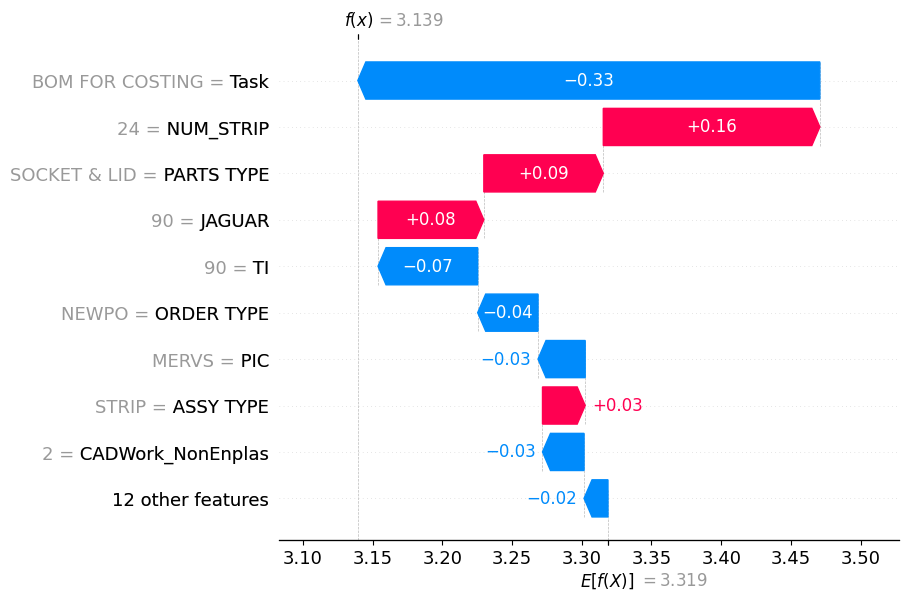

,Feature,Mean_Abs_SHAP
0,Task,0.389998
20,PIC,0.213070
19,NUM_STRIP,0.203902
10,TI,0.161393
3,ORDER TYPE,0.121918
2,PARTS TYPE,0.119549
15,CADWork_NonEnplas,0.057830
1,ASSY TYPE,0.046978
18,NUM_SITE,0.040167
6,JAGUAR,0.024040


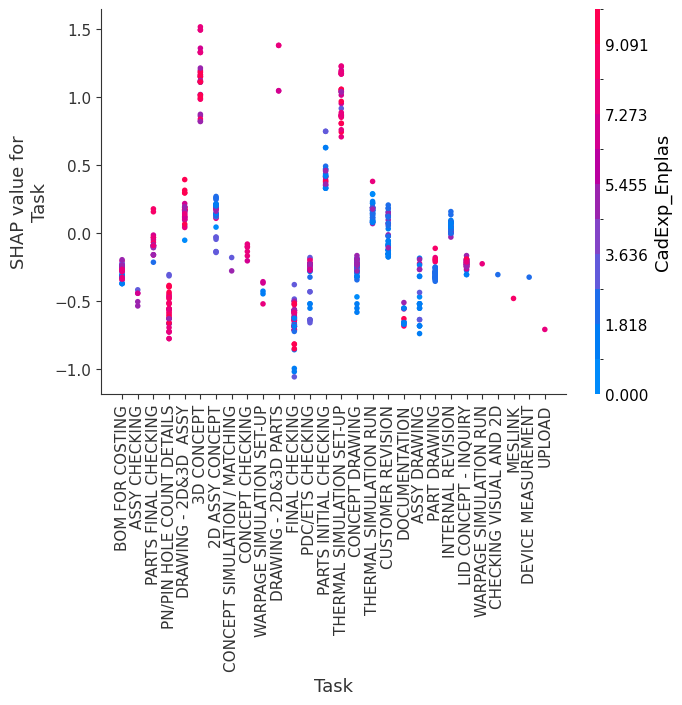

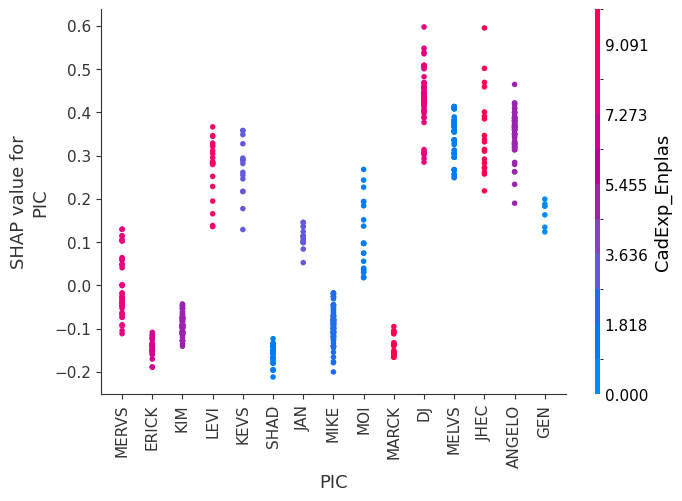

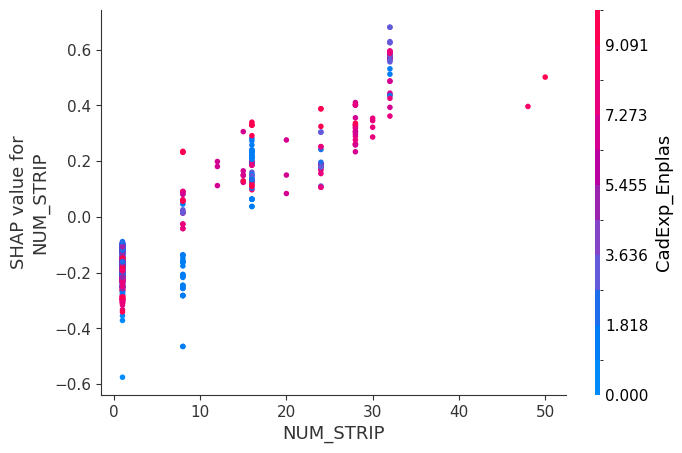

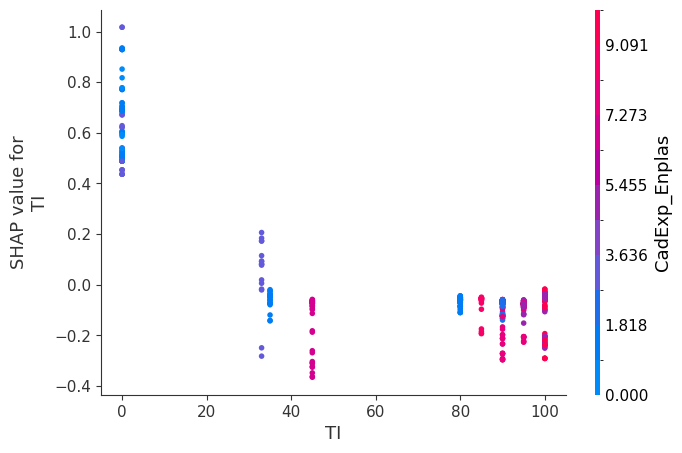

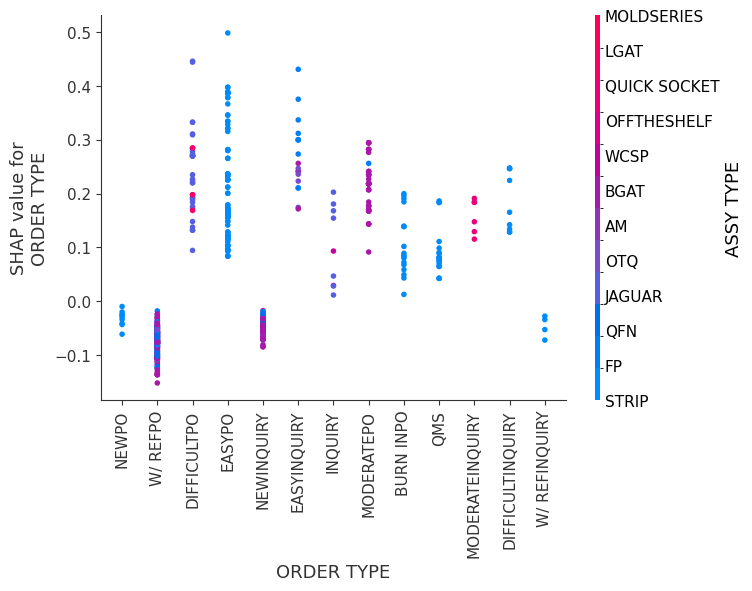

In [19]:
#df_ml_dataset = df_ml_expanded[['Date',  'Task', 'ASSY TYPE', 'PARTS TYPE',
 #                               'ORDER TYPE', 'SITE_TYPE','PN_PREFIX',
  #                              'JAGUAR', 'WCSP', 'STRIP', 'BI', 'TI',	'NON TI', 
   #                             'Designation',
    #                            'CadExp_Enplas', 'Enplas_Years', 'CADWork_NonEnplas',
     #                           'NonCadWork', 'Total',
      #                          'NUM_SITE', 'NUM_STRIP', 'PIC',
       #                         'Total Adj Time Spent']]

df_ml_dataset = df_ml_expanded[['Date',  'Task', 'ASSY TYPE', 'PARTS TYPE', 'ORDER TYPE',
                                'SITE_TYPE','PN_PREFIX',
                                'JAGUAR', 'WCSP', 'STRIP', 'BI', 'TI',	'NON TI', 
                                'Designation',
                                'CadExp_Enplas', 'Enplas_Years', 'CADWork_NonEnplas',
                                'NonCadWork', 'Total',
                                'NUM_SITE', 'NUM_STRIP', 'PIC',
                                'Total Adj Time Spent']]

#cat_cols = ['Task', 'ASSY TYPE', 'PARTS TYPE',
 #           'ORDER TYPE', 'SITE_TYPE','PN_PREFIX',
  #          'JAGUAR', 'WCSP', 'STRIP', 'BI', 'TI',	'NON TI','Designation']

cat_cols = ['Task', 'ASSY TYPE', 'PARTS TYPE','ORDER TYPE',
            'PIC', 'SITE_TYPE','PN_PREFIX',
            'Designation']

best_model, cv_rmse, rmse, mae, mape, r2 = gbm_hyperparameter_tuning(df_ml_dataset,
                                                          'Total Adj Time Spent',
                                                          cat_cols,
                                                          date_cutoff,
                                                          n_splits)

ml_results_summary['LightGBM']= [best_model, cv_rmse, rmse, mae, mape, r2]

In [ ]:
df_ml_expanded.head(5)

,ID,Task,Total Adj Time Spent,PN,PRODUCT-ASSY TYPE,ASSY TYPE,PARTS TYPE,ORDER TYPE,INQUIRY_OR_PO,Order Type,...,STRIP,BI,TI,NON TI,Designation,CadExp_Enplas,Enplas_Years,CADWork_NonEnplas,NonCadWork,Total
0,1,DRAWING - 2D&3D ASSY,27.0,QFN-28X32EPK-0.5-001,JAGUARSOCKETDIFFICULTPO,JAGUAR,SOCKET,DIFFICULTPO,PO,PO,...,0,0,0,0,ADE,3.0,11.0,0.0,0.0,11.0
1,1,FINAL CHECKING,3.0,QFN-28X32EPK-0.5-001,JAGUARSOCKETDIFFICULTPO,JAGUAR,SOCKET,DIFFICULTPO,PO,PO,...,0,0,100,100,ADE,10.0,14.0,0.0,0.0,14.0
2,1,THERMAL SIMULATION SET-UP,7.0,QFN-28X32EPK-0.5-001,JAGUARSOCKETDIFFICULTPO,JAGUAR,SOCKET,DIFFICULTPO,PO,PO,...,100,0,100,100,DE,10.0,13.0,0.0,6.0,19.0
3,4,CONCEPT CHECKING,11.0,FP-28X35EPK-0.65-001-C0,JAGUARLIDDIFFICULTPO,JAGUAR,LID,DIFFICULTPO,PO,PO,...,100,0,100,100,DE,10.0,13.0,0.0,6.0,19.0
4,4,DRAWING - 2D&3D ASSY,2.0,FP-28X35EPK-0.65-001-C0,JAGUARLIDDIFFICULTPO,JAGUAR,LID,DIFFICULTPO,PO,PO,...,0,0,0,0,ADE,3.0,11.0,0.0,0.0,11.0


In [18]:
df_ml_expanded.columns

Index(['ID', 'Task', 'Total Adj Time Spent', 'PN', 'PRODUCT-ASSY TYPE',
       'ASSY TYPE', 'PARTS TYPE', 'ORDER TYPE', 'INQUIRY_OR_PO', 'Order Type',
       'Date', 'PIC Count', 'PIC', 'NUM_SITE', 'NUM_STRIP', 'SITE_TYPE',
       'PN_PREFIX', 'JAGUAR', 'WCSP', 'STRIP', 'BI', 'TI', 'NON TI',
       'Designation', 'CadExp_Enplas', 'Enplas_Years', 'CADWork_NonEnplas',
       'NonCadWork', 'Total'],
      dtype='object')

#### Catboost

In [14]:
from catboost import CatBoostRegressor, Pool


def show_model_interpretation(jaguar_model, X_valid):
    X_display = X_valid.copy()

    # Encode categorical features just for SHAP internals
    X_encoded = X_valid.copy()
    for col in X_encoded.select_dtypes(include=['object', 'category']).columns:
        X_encoded[col] = X_encoded[col].astype('category').cat.codes

    explainer = shap.TreeExplainer(jaguar_model)
    shap_values = explainer.shap_values(X_encoded)

    # SHAP summary using original feature names
    shap.summary_plot(shap_values, X_display, plot_type='bar')
    shap.summary_plot(shap_values, X_display)

    # Force plot
    shap.initjs()
    shap.force_plot(explainer.expected_value, shap_values[0], X_display.iloc[0], matplotlib=True)

    # Waterfall plot
    shap.plots.waterfall(shap.Explanation(
        values=shap_values[0],
        base_values=explainer.expected_value,
        data=X_display.iloc[0],
        feature_names=X_display.columns.tolist()
    ))

    # Top features by mean absolute SHAP value
    mean_abs_shap = pd.DataFrame({
        'Feature': X_display.columns,
        'Mean_Abs_SHAP': np.abs(shap_values).mean(axis=0)
    }).sort_values('Mean_Abs_SHAP', ascending=False)

    display(mean_abs_shap.head(20))

    # Dependence plots — use encoded values for SHAP, original for display
    for feature in mean_abs_shap['Feature'].head(5):
        shap.dependence_plot(feature, shap_values, X_encoded, display_features=X_display)




def ml_hyperparameter_tuning(df_ml, target_col, cat_cols,
                              date_cutoff, n_splits=3, gap=0, window_type='expanding',
                              drop_cols=None):

    if drop_cols is None:
        drop_cols = ['Date']

    # --- Step 1: Split data into train/holdout based on date ---
    df = df_ml.sort_values('Date').reset_index(drop=True)
    df_train = df[df['Date'] < date_cutoff].copy()
    df_valid = df[df['Date'] >= date_cutoff].copy()

    category_mappings = {}
    for col in cat_cols:
        df_train[col] = df_train[col].astype('category')
        df_valid[col] = df_valid[col].astype('category')
        category_mappings[col] = dict(enumerate(df_train[col].cat.categories))

    y_train = df_train[target_col]
    y_valid = df_valid[target_col]
    X_train = df_train.drop(columns=[target_col])
    X_valid = df_valid.drop(columns=[target_col])

    # --- Step 2: Drop unwanted columns (e.g., Date) ---
    dropper = ColumnDropper(columns_to_drop=drop_cols)
    X_train_dropped = dropper.fit_transform(X_train)
    X_valid_dropped = dropper.transform(X_valid)

    # --- Step 3: Categorical column names (CatBoost expects names, not indices when using DataFrames) ---
    cat_features = [col for col in cat_cols if col in X_train_dropped.columns]

    # --- Step 4: Cross-validation splitter ---
    splitter = DateTimeSeriesSplit(
        date_column='Date',
        n_splits=n_splits,
        gap=gap,
        window_type=window_type
    )

    # --- Step 5: Optuna objective ---
    def objective(trial):
        params = {
            "iterations": trial.suggest_int("iterations", 300, 1000),
            "depth": trial.suggest_int("depth", 4, 10),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
            "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-2, 10.0, log=True),
            "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
            "border_count": trial.suggest_int("border_count", 32, 255),
            "random_strength": trial.suggest_float("random_strength", 0.0, 10.0),
            "verbose": 0,
            "early_stopping_rounds": 20,
            "task_type": "CPU"
        }

        scores = []
        for train_idx, val_idx in splitter.split(df_train):
            X_tr = X_train_dropped.iloc[train_idx]
            y_tr = y_train.iloc[train_idx]
            X_te = X_train_dropped.iloc[val_idx]
            y_te = y_train.iloc[val_idx]

            train_pool = Pool(X_tr, y_tr, cat_features=cat_features)
            valid_pool = Pool(X_te, y_te, cat_features=cat_features)

            model = CatBoostRegressor(**params)
            model.fit(train_pool, eval_set=valid_pool, use_best_model=True)

            preds = model.predict(X_te)
            scores.append(r2_score(y_te, preds))

        return np.mean(scores)

    # --- Step 6: Run Optuna search ---
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=50, show_progress_bar=True)

    print("Best parameters:", study.best_params)
    print("Best CV R2:", study.best_value)
    cv_r2 = study.best_value

    # --- Step 7: Train final model on full training data ---
    best_params = study.best_params
    best_params.update({
        "verbose": 0,
        "loss_function": "MAE",
        "early_stopping_rounds": 20,
        "task_type": "CPU"
    })

    final_model = CatBoostRegressor(**best_params)
    train_pool = Pool(X_train_dropped, y_train, cat_features=cat_features)
    valid_pool = Pool(X_valid_dropped, y_valid, cat_features=cat_features)
    #final_model.fit(train_pool, eval_set=valid_pool, use_best_model=True)
    final_model.fit(train_pool, use_best_model=True)
    
    y_pred = final_model.predict(X_valid_dropped)
    rmse = root_mean_squared_error(y_valid, y_pred)
    print("Validation RMSE:", rmse)

    mae = mean_absolute_error(y_valid, y_pred)
    print("Validation MAE:", mae)    

    mape = mean_absolute_percentage_error(y_valid, y_pred)
    print("Validation MAPE:", mape)

    r2 = r2_score(y_valid, y_pred)
    print("Validation R2:", r2)    
    
    show_model_interpretation(final_model, X_valid_dropped)

    
    
    return final_model, cv_r2, rmse, mae, mape, r2

[I 2025-05-24 13:16:24,904] A new study created in memory with name: no-name-c4802794-7e81-41eb-b12f-c994443fad93


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-05-24 13:16:48,318] Trial 0 finished with value: 0.29101647040375794 and parameters: {'iterations': 387, 'depth': 7, 'learning_rate': 0.053394898805149395, 'l2_leaf_reg': 3.86605942087999, 'bagging_temperature': 0.9843897264282846, 'border_count': 168, 'random_strength': 1.2044708754018063}. Best is trial 0 with value: 0.29101647040375794.
[I 2025-05-24 13:17:06,679] Trial 1 finished with value: 0.2800208705843598 and parameters: {'iterations': 534, 'depth': 5, 'learning_rate': 0.06465331852133235, 'l2_leaf_reg': 0.04557008875488532, 'bagging_temperature': 0.06946568810312403, 'border_count': 90, 'random_strength': 5.494989859736292}. Best is trial 0 with value: 0.29101647040375794.
[I 2025-05-24 13:17:16,058] Trial 2 finished with value: 0.2586779912030766 and parameters: {'iterations': 784, 'depth': 5, 'learning_rate': 0.15389063576217768, 'l2_leaf_reg': 2.988064407471257, 'bagging_temperature': 0.026640626265872158, 'border_count': 194, 'random_strength': 4.509941223160405}.

You should provide test set for use best model. use_best_model parameter has been switched to false value.


Validation RMSE: 3.1111453809680727
Validation MAE: 1.7243076711211003
Validation MAPE: 15283905803193.492
Validation R2: 0.31899567851499677


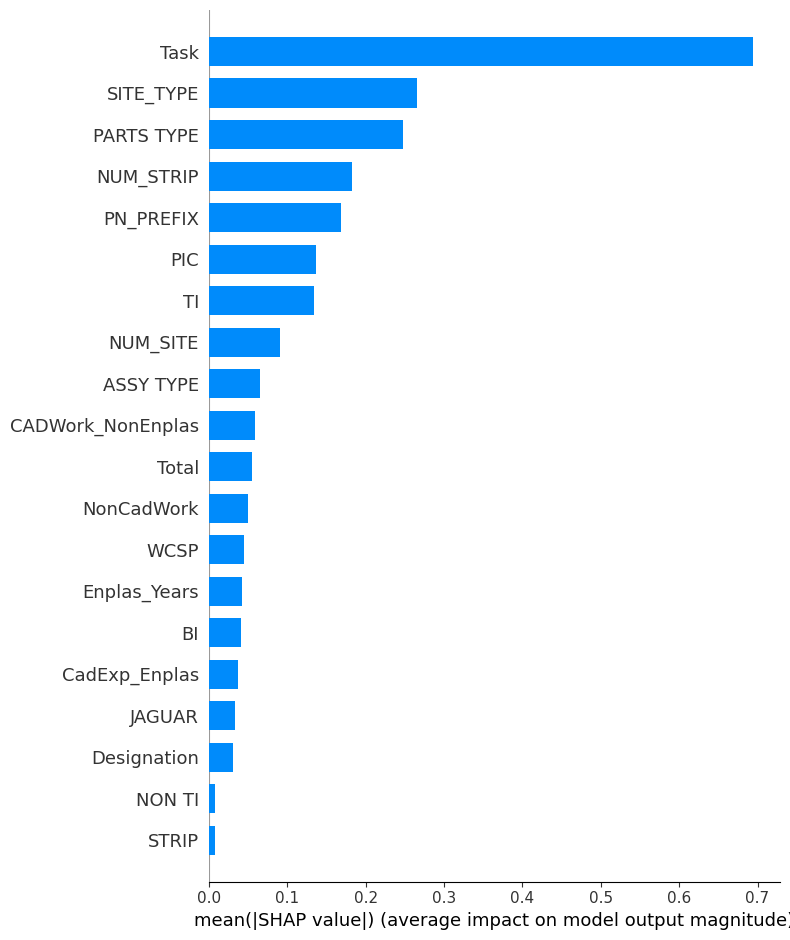

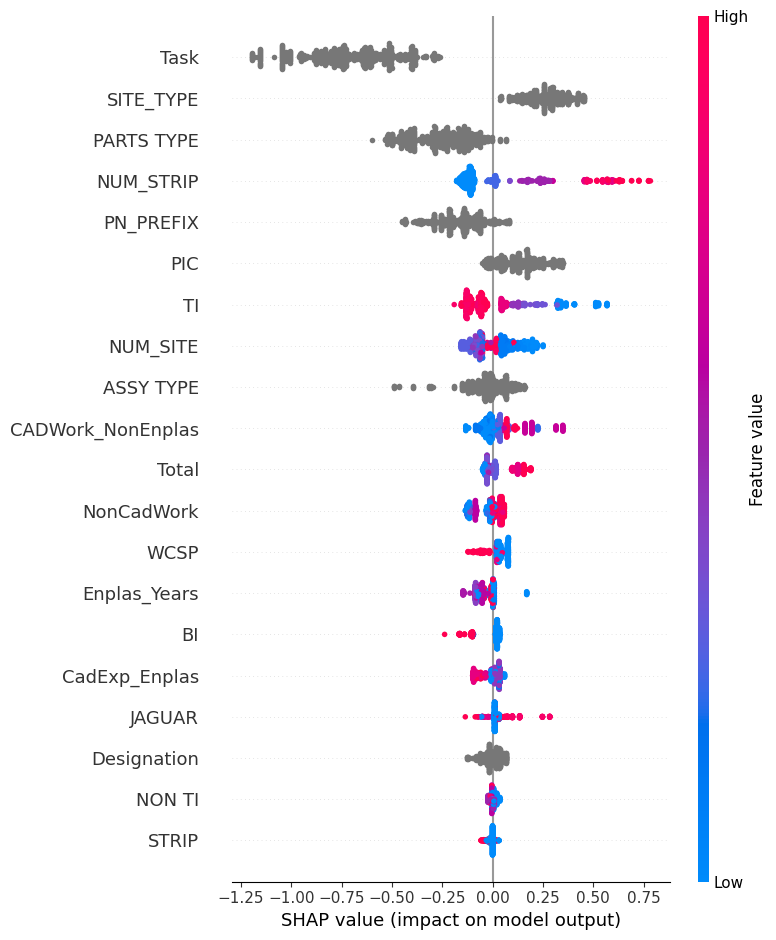

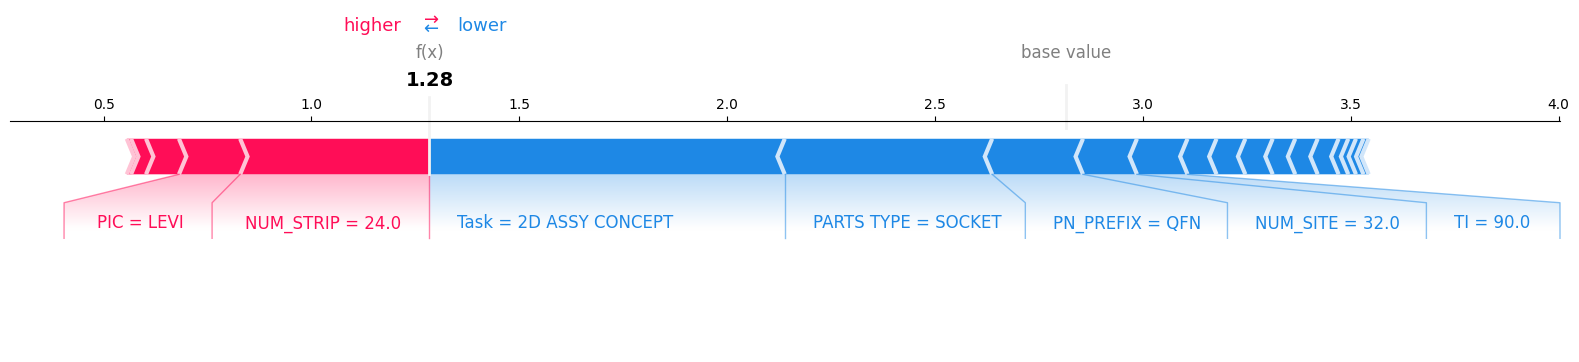

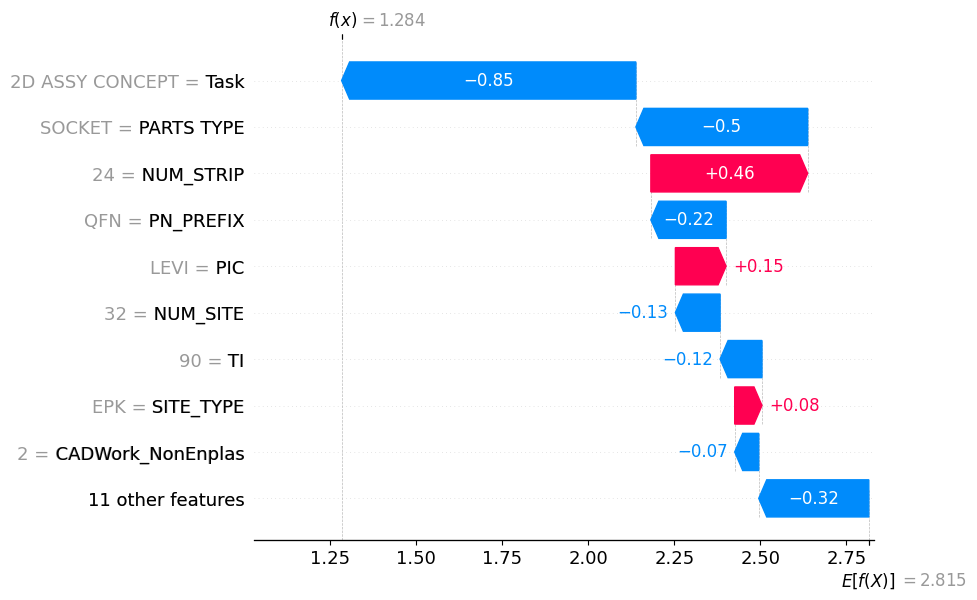

,Feature,Mean_Abs_SHAP
0,Task,0.693974
3,SITE_TYPE,0.265333
2,PARTS TYPE,0.247763
18,NUM_STRIP,0.182938
4,PN_PREFIX,0.168340
19,PIC,0.137113
9,TI,0.133632
17,NUM_SITE,0.090514
1,ASSY TYPE,0.065648
14,CADWork_NonEnplas,0.058359


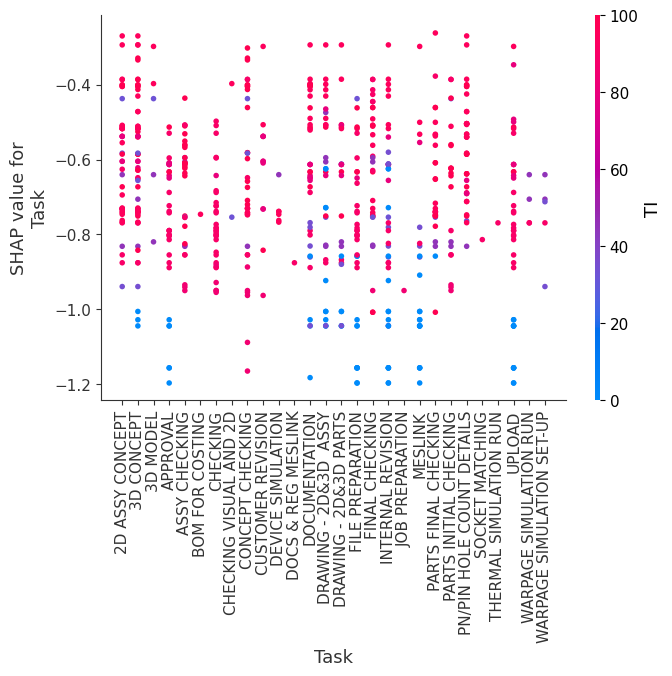

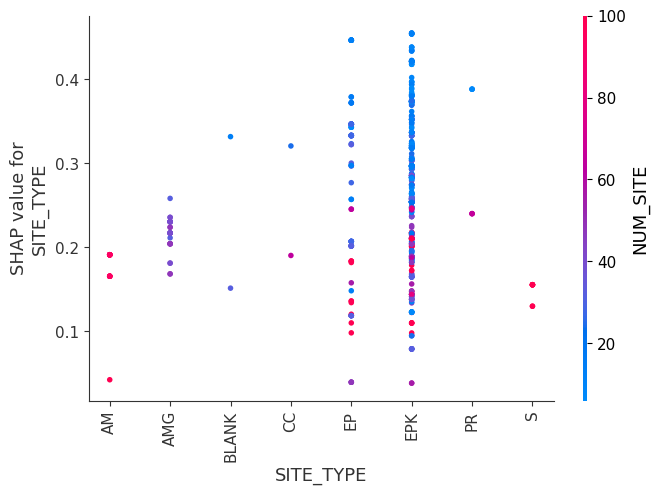

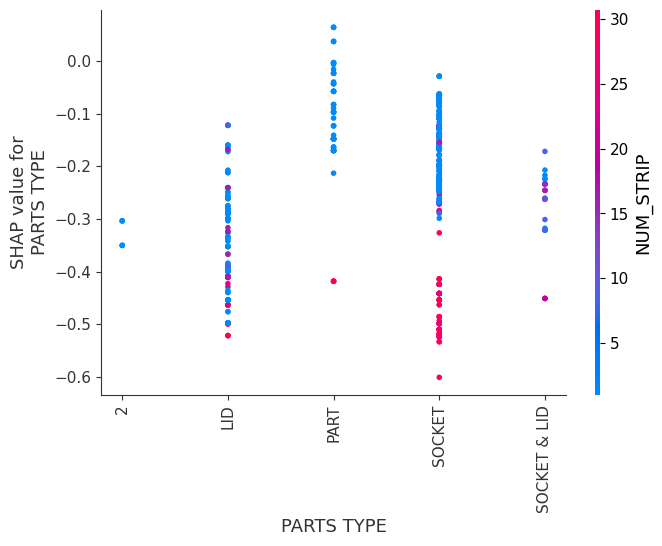

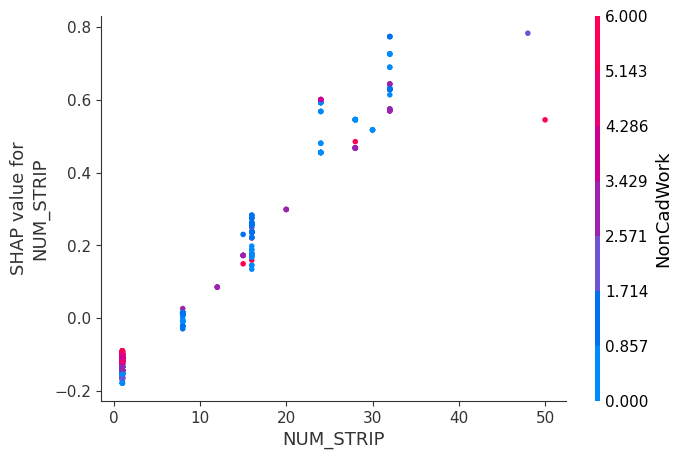

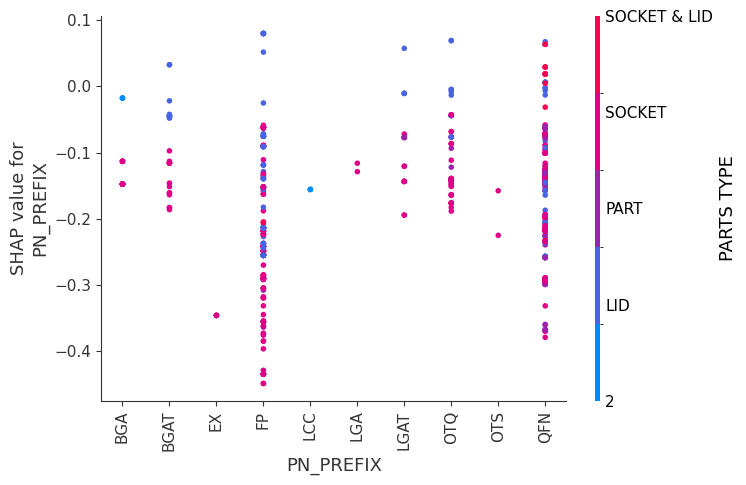

In [15]:
best_model, cv_rmse, rmse, mae, mape, r2 = ml_hyperparameter_tuning(df_ml_dataset,
                                                          'Total Adj Time Spent',
                                                          cat_cols,
                                                          date_cutoff,
                                                          n_splits)

ml_results_summary['CatBoost']= [best_model, cv_rmse, rmse, mae, mape, r2]

#### Linear Regression

In [17]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

def explain_linear_model(model, feature_names, top_n=20):
    coefs = model.coef_
    coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefs})
    coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
    coef_df = coef_df.sort_values('Abs_Coefficient', ascending=False).head(top_n)

    plt.figure(figsize=(10, 6))
    plt.barh(coef_df['Feature'], coef_df['Coefficient'], color='skyblue')
    plt.title('Top Feature Importances')
    plt.axvline(0, color='grey', linewidth=1)
    plt.xlabel('Coefficient Value')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()


def tune_regularized_linear_model(df_ml, target_col, cat_cols, date_cutoff,
                                   n_splits=3, gap=0, window_type='expanding', model_type='ridge'):
    assert model_type in ['ridge', 'lasso'], "model_type must be 'ridge' or 'lasso'"

    df = df_ml.sort_values('Date').reset_index(drop=True)

    # Ensure categoricals are strings for OneHotEncoder
    for col in cat_cols:
        df[col] = df[col].astype(str)

    # Train/holdout split
    df_train = df[df['Date'] < date_cutoff].copy()
    df_valid = df[df['Date'] >= date_cutoff].copy()

    y_train = df_train[target_col]
    y_valid = df_valid[target_col]
    X_train = df_train.drop(columns=[target_col])
    X_valid = df_valid.drop(columns=[target_col])

    dropper = ColumnDropper(columns_to_drop=['Date'])
    X_train_dropped = dropper.fit_transform(X_train)
    X_valid_dropped = dropper.transform(X_valid)

    # Detect numeric columns
    num_cols = X_train_dropped.select_dtypes(include=['int64', 'float64']).columns.tolist()
    num_cols = [col for col in num_cols if col not in cat_cols]

    # Preprocessing: One-hot encode categoricals, passthrough numerics
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols),
            ('num', StandardScaler(), num_cols)
        ],
        remainder='drop'  # Only cat and num are kept; others (if any) are dropped
    )

    splitter = DateTimeSeriesSplit(
        date_column='Date',
        n_splits=n_splits,
        gap=gap,
        window_type=window_type
    )

    def objective(trial):
        alpha = trial.suggest_float("alpha", 1e-4, 100.0, log=True)

        scores = []
        for train_idx, val_idx in splitter.split(df_train):
            X_tr = X_train_dropped.iloc[train_idx]
            y_tr = y_train.iloc[train_idx]
            X_te = X_train_dropped.iloc[val_idx]
            y_te = y_train.iloc[val_idx]

            model = Pipeline(steps=[
                ('preprocessor', preprocessor),
                ('lr', Ridge(alpha=alpha) if model_type == 'ridge'
                 else Lasso(alpha=alpha, max_iter=10000))
            ])

            model.fit(X_tr, y_tr)
            preds = model.predict(X_te)
            scores.append(r2_score(y_te, preds))

        return -np.mean(scores)

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=50)

    print("Best parameters:", study.best_params)
    print("Best CV R2:", study.best_value)
    
    cv_r2 = study.best_value
    # Final model with best alpha
    alpha = study.best_params['alpha']
    final_model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('lr', Ridge(alpha=alpha) if model_type == 'ridge'
         else Lasso(alpha=alpha, max_iter=10000))
    ])
    final_model.fit(X_train_dropped, y_train)
    y_pred = final_model.predict(X_valid_dropped)

    rmse = root_mean_squared_error(y_valid, y_pred)
    print("Validation RMSE:", rmse)

    mae = mean_absolute_error(y_valid, y_pred)
    print("Validation MAE:", mae)

    mape = mean_absolute_percentage_error(y_valid, y_pred)
    print("Validation MAPE:", mape)

    r2 = r2_score(y_valid, y_pred)
    print("Validation R2:", r2)       

    # Extract and display feature importances
    ohe = final_model.named_steps['preprocessor'].named_transformers_['cat']
    ohe_feature_names = ohe.get_feature_names_out(cat_cols)
    all_feature_names = np.concatenate([ohe_feature_names, num_cols])

    lr_model = final_model.named_steps['lr']
    explain_linear_model(lr_model, all_feature_names)

    return final_model, cv_r2, rmse, mae, mape, r2

##### Ridge Regression

[I 2025-05-10 18:55:03,439] A new study created in memory with name: no-name-faa41645-e42d-48a7-b534-89df35474e4d
[I 2025-05-10 18:55:04,248] Trial 0 finished with value: 0.07080949235580547 and parameters: {'alpha': 0.8777588212049998}. Best is trial 0 with value: 0.07080949235580547.
[I 2025-05-10 18:55:05,232] Trial 1 finished with value: -0.034583678776714165 and parameters: {'alpha': 4.999973780495936}. Best is trial 1 with value: -0.034583678776714165.
[I 2025-05-10 18:55:06,047] Trial 2 finished with value: 0.09054848310903456 and parameters: {'alpha': 0.4943962316141011}. Best is trial 1 with value: -0.034583678776714165.
[I 2025-05-10 18:55:06,951] Trial 3 finished with value: 0.10519250572852216 and parameters: {'alpha': 0.2566902397918212}. Best is trial 1 with value: -0.034583678776714165.
[I 2025-05-10 18:55:07,946] Trial 4 finished with value: -0.03305361083517966 and parameters: {'alpha': 4.894939207104654}. Best is trial 1 with value: -0.034583678776714165.
[I 2025-05-1

Best parameters: {'alpha': 71.91114518937161}
Best CV R2: -0.14589782448781338
Validation RMSE: 3.4620927777294583
Validation MAE: 2.2580538212112264
Validation MAPE: 1.5747288881075292
Validation R2: 0.22650392520373586


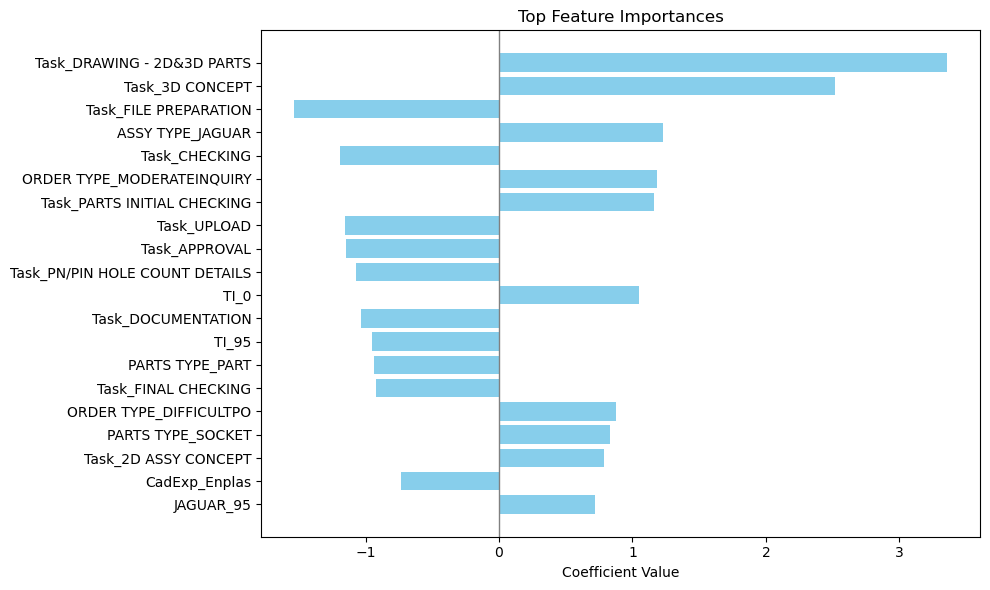

In [18]:
best_model, cv_rmse, rmse, mae, mape, r2 = tune_regularized_linear_model(df_ml_dataset,
                                                               'Total Adj Time Spent',
                                                               cat_cols, 
                                                               date_cutoff,
                                                               n_splits)
ml_results_summary['Ridge']= [best_model, cv_rmse, rmse, mae, mape, r2]

##### Lasso Regression

[I 2025-05-10 18:55:49,414] A new study created in memory with name: no-name-f4d0f156-27d8-4c01-bf00-e6e0fb99e98c
[I 2025-05-10 18:55:49,984] Trial 0 finished with value: 0.033541190604678604 and parameters: {'alpha': 49.489870909850694}. Best is trial 0 with value: 0.033541190604678604.
[I 2025-05-10 18:56:03,443] Trial 1 finished with value: 0.08303070386467055 and parameters: {'alpha': 0.0011642749730569404}. Best is trial 0 with value: 0.033541190604678604.
[I 2025-05-10 18:56:04,441] Trial 2 finished with value: -0.14773384432664918 and parameters: {'alpha': 0.06517842528098625}. Best is trial 2 with value: -0.14773384432664918.
[I 2025-05-10 18:56:05,284] Trial 3 finished with value: 0.00898070001864785 and parameters: {'alpha': 0.5866488558490012}. Best is trial 2 with value: -0.14773384432664918.
[I 2025-05-10 18:56:06,442] Trial 4 finished with value: -0.09703808484591987 and parameters: {'alpha': 0.024909589845805546}. Best is trial 2 with value: -0.14773384432664918.
[I 2025

Best parameters: {'alpha': 0.08177275773326609}
Best CV R2: -0.15260734343261095
Validation RMSE: 3.6729685654991826
Validation MAE: 2.5242558786321627
Validation MAPE: 2.0513374825397728
Validation R2: 0.12940707550917951


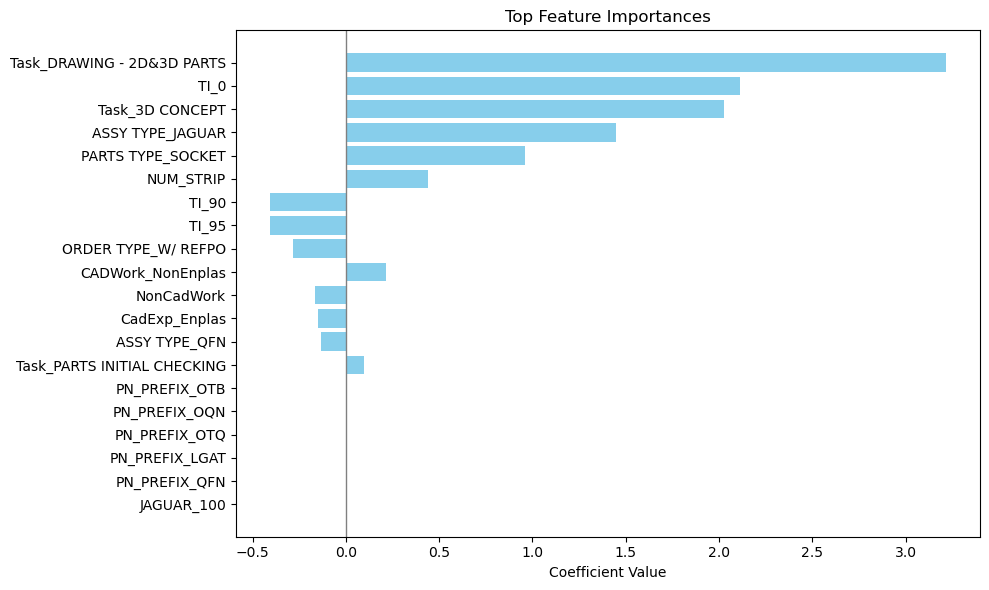

In [19]:
best_model, cv_rmse, rmse, mae, mape, r2 = tune_regularized_linear_model(df_ml_dataset,
                                                               'Total Adj Time Spent',
                                                               cat_cols,
                                                               date_cutoff,
                                                               n_splits,
                                                               model_type='lasso')
ml_results_summary['Lasso']= [best_model, cv_rmse, rmse, mae, mape, r2]

#### Random Forest

In [20]:
from sklearn.ensemble import RandomForestRegressor

def show_rf_model_explainability(model_pipeline, X_valid):
    # Extract the trained RandomForestRegressor and transformed data
    preprocessor = model_pipeline.named_steps['preprocessor']
    rf_model = model_pipeline.named_steps['rf']
    
    # Transform X_valid using the preprocessor to get encoded features
    X_transformed = preprocessor.transform(X_valid)

    # Get feature names after transformation
    try:
        feature_names = preprocessor.get_feature_names_out()
    except:
        # fallback for older sklearn versions
        cat_features = preprocessor.transformers_[0][2]
        feature_names = (
            model_pipeline.named_steps['preprocessor']
            .named_transformers_['cat']
            .get_feature_names(cat_features)
            .tolist()
        )
        remainder_features = [col for col in X_valid.columns if col not in cat_features]
        feature_names += remainder_features

    # Create a DataFrame for SHAP
    X_transformed_df = pd.DataFrame(X_transformed.toarray() if hasattr(X_transformed, "toarray") else X_transformed,
                                    columns=feature_names)

    explainer = shap.TreeExplainer(rf_model)
    shap_values = explainer.shap_values(X_transformed_df)

    # Summary plots
    shap.summary_plot(shap_values, X_transformed_df, plot_type="bar")
    shap.summary_plot(shap_values, X_transformed_df)

    # Force + waterfall plot for one example
    shap.initjs()
    shap.force_plot(explainer.expected_value, shap_values[0], X_transformed_df.iloc[0], matplotlib=True)
    shap.plots.waterfall(shap.Explanation(
        values=shap_values[0],
        base_values=explainer.expected_value,
        data=X_transformed_df.iloc[0],
        feature_names=X_transformed_df.columns.tolist()
    ))

    # Top features
    mean_abs_shap = pd.DataFrame({
        'Feature': X_transformed_df.columns,
        'Mean_Abs_SHAP': np.abs(shap_values).mean(axis=0)
    }).sort_values('Mean_Abs_SHAP', ascending=False)

    display(mean_abs_shap.head(10))

    for feature in mean_abs_shap['Feature'].head(3):
        shap.dependence_plot(feature, shap_values, X_transformed_df)

def tune_random_forest_model(df_ml, target_col, cat_cols, date_cutoff,
                                   n_splits=3, gap=0, window_type='expanding'):

    df = df_ml.sort_values('Date').reset_index(drop=True)

    # Ensure categoricals are strings for OneHotEncoder
    for col in cat_cols:
        df[col] = df[col].astype(str)

    # Train/holdout split
    df_train = df[df['Date'] < date_cutoff].copy()
    df_valid = df[df['Date'] >= date_cutoff].copy()

    y_train = df_train[target_col]
    y_valid = df_valid[target_col]
    X_train = df_train.drop(columns=[target_col])
    X_valid = df_valid.drop(columns=[target_col])

    dropper = ColumnDropper(columns_to_drop=['Date'])
    X_train_dropped = dropper.fit_transform(X_train)
    X_valid_dropped = dropper.transform(X_valid)

    # Detect numeric columns
    num_cols = X_train_dropped.select_dtypes(include=['int64', 'float64']).columns.tolist()
    num_cols = [col for col in num_cols if col not in cat_cols]

    # Preprocessing: One-hot encode categoricals, passthrough numerics
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
        ],
        remainder='passthrough'
    )

    splitter = DateTimeSeriesSplit(
        date_column='Date',
        n_splits=n_splits,
        gap=gap,
        window_type=window_type
    )

    def objective(trial):
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 100, 500),
            "max_depth": trial.suggest_int("max_depth", 5, 20),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 5),
            "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None])
        }
        scores = []
        for train_idx, val_idx in splitter.split(df_train):
            X_tr = X_train_dropped.iloc[train_idx]
            y_tr = y_train.iloc[train_idx]
            X_te = X_train_dropped.iloc[val_idx]
            y_te = y_train.iloc[val_idx]
    
            model = Pipeline(steps=[
                ('preprocessor', preprocessor),
                ('rf', RandomForestRegressor(**params, random_state=42))
            ])

            model.fit(X_tr, y_tr)
            preds = model.predict(X_te)
            scores.append(r2_score(y_te, preds))

        return np.mean(scores)

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=50)

    print("Best parameters:", study.best_params)
    print("Best CV R2:", study.best_value)

    cv_r2 = study.best_value

    best_params = study.best_params
    final_model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('rf', RandomForestRegressor(**best_params, random_state=42))
    ])
    final_model.fit(X_train_dropped, y_train)
    y_pred = final_model.predict(X_valid_dropped)

    rmse = root_mean_squared_error(y_valid, y_pred)
    print("Validation RMSE:", rmse)

    mae = mean_absolute_error(y_valid, y_pred)
    print("Validation MAE:", mae)

    mape = mean_absolute_percentage_error(y_valid, y_pred)
    print("Validation MAPE:", mape)

    r2 = r2_score(y_valid, y_pred)
    print("Validation R2:", r2)   
    
    show_rf_model_explainability(final_model, X_valid_dropped)
    
    return final_model, cv_r2, rmse, mae, mape, r2

[I 2025-05-10 18:59:08,230] A new study created in memory with name: no-name-62ad2c23-8dbe-4c86-ad74-e2fec13d5435
[I 2025-05-10 18:59:10,082] Trial 0 finished with value: 0.16086268125634695 and parameters: {'n_estimators': 332, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 0 with value: 0.16086268125634695.
[I 2025-05-10 18:59:22,808] Trial 1 finished with value: 0.19572039294434684 and parameters: {'n_estimators': 399, 'max_depth': 18, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 1 with value: 0.19572039294434684.
[I 2025-05-10 18:59:30,502] Trial 2 finished with value: 0.202041498639598 and parameters: {'n_estimators': 312, 'max_depth': 11, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 2 with value: 0.202041498639598.
[I 2025-05-10 18:59:33,066] Trial 3 finished with value: 0.16421710323647842 and parameters: {'n_estimators': 453, 'max_depth': 8, 'min_

Best parameters: {'n_estimators': 263, 'max_depth': 11, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': None}
Best CV R2: 0.21665934438271928
Validation RMSE: 3.445295977380635
Validation MAE: 2.0748213131292945
Validation MAPE: 1.4811882777837901
Validation R2: 0.23399115511956903


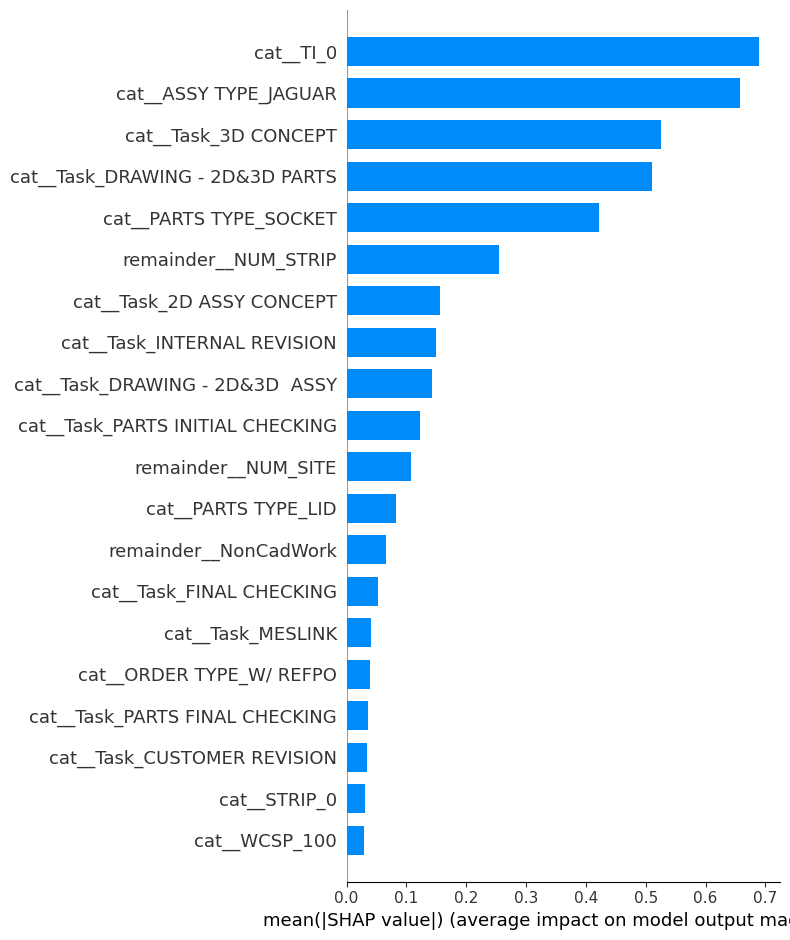

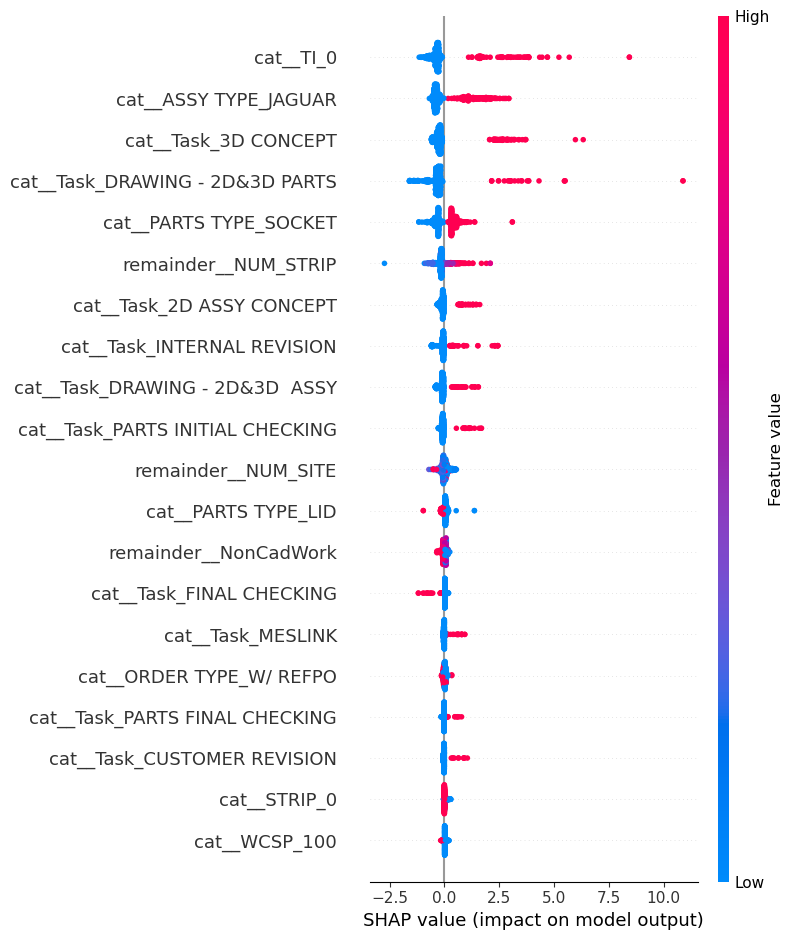

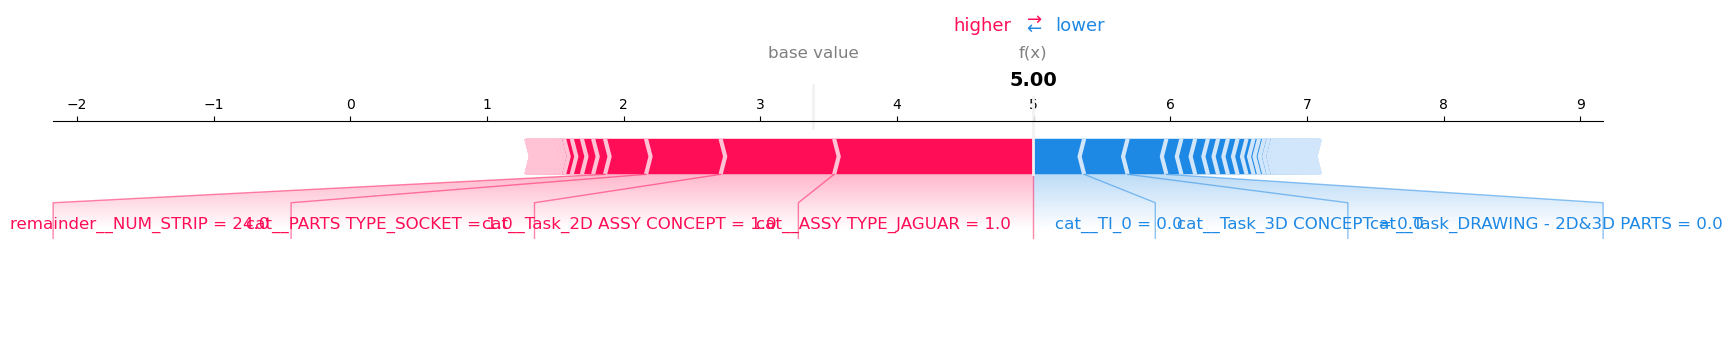

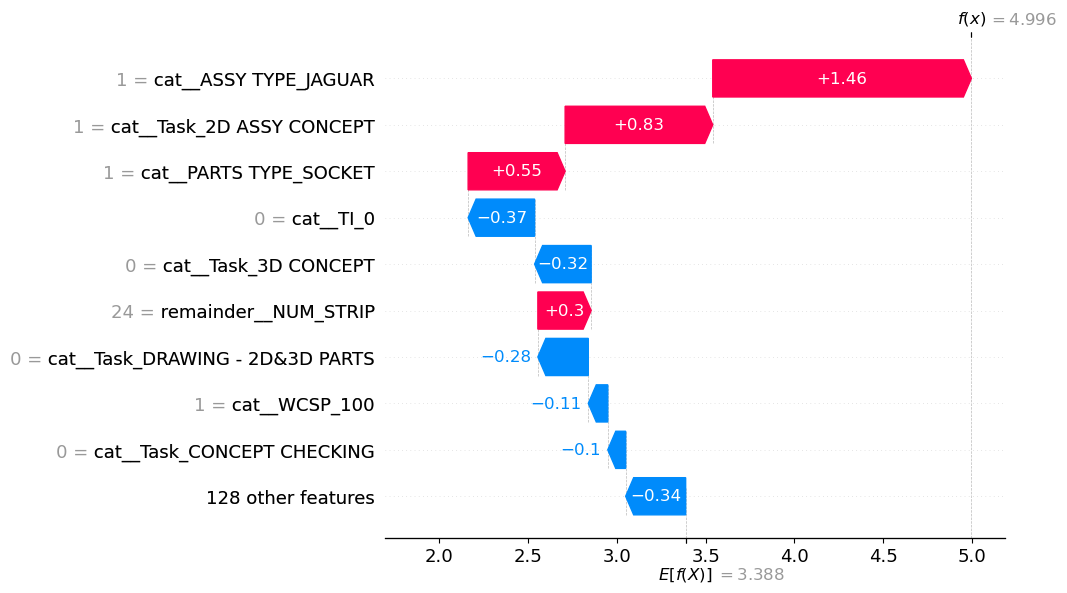

,Feature,Mean_Abs_SHAP
113,cat__TI_0,0.689907
36,cat__ASSY TYPE_JAGUAR,0.658102
2,cat__Task_3D CONCEPT,0.525893
16,cat__Task_DRAWING - 2D&3D PARTS,0.510877
49,cat__PARTS TYPE_SOCKET,0.422328
136,remainder__NUM_STRIP,0.255460
0,cat__Task_2D ASSY CONCEPT,0.155724
20,cat__Task_INTERNAL REVISION,0.148700
15,cat__Task_DRAWING - 2D&3D ASSY,0.142893
25,cat__Task_PARTS INITIAL CHECKING,0.122190


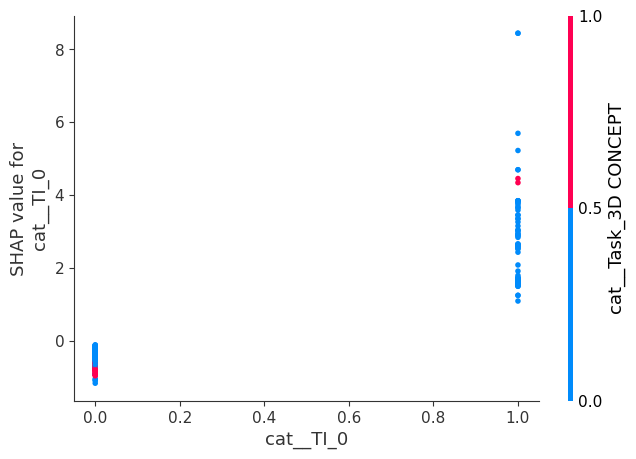

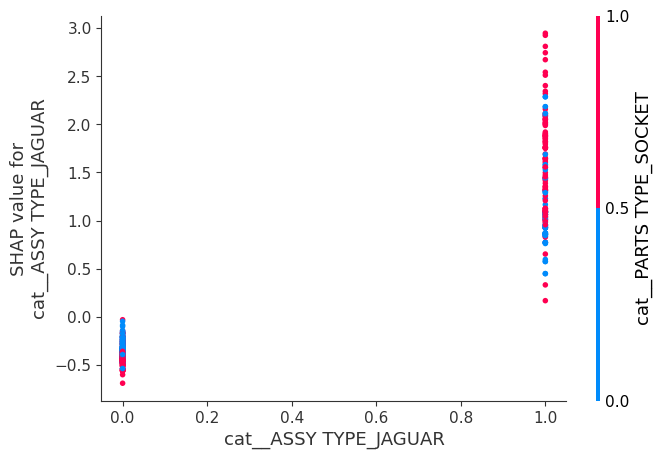

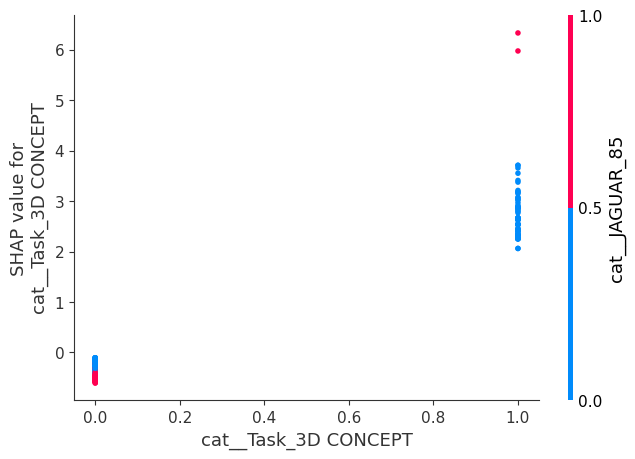

In [21]:
best_model, cv_rmse, rmse, mae, mape, r2 = tune_random_forest_model(df_ml_dataset,
                                                          'Total Adj Time Spent',
                                                          cat_cols,
                                                          date_cutoff,
                                                          n_splits)
ml_results_summary['Random Forest']= [best_model, cv_rmse, rmse, mae, mape, r2]

#### Summarize Results

In [22]:
data=[]
for key, value in ml_results_summary.items():
    data.append([key, value[1], value[2], value[3], value[4], value[5]])
df_summary = pd.DataFrame(data, columns=['Model','CV R2','Holdout RMSE','Holdout MAE','Holdout MAPE','Holdout R2'])
display(df_summary)

,Model,CV R2,Holdout RMSE,Holdout MAE,Holdout MAPE,Holdout R2
0,Baseline,-0.287173,3.785402,2.116236,1.211115,0.075292
1,LightGBM,0.303729,3.883292,2.653738,2.508790,0.026848
2,CatBoost,0.325334,3.201462,1.791990,0.912670,0.338580
3,Ridge,-0.145898,3.462093,2.258054,1.574729,0.226504
4,Lasso,-0.152607,3.672969,2.524256,2.051337,0.129407
5,Random Forest,0.216659,3.445296,2.074821,1.481188,0.233991


#### Check suitability for ARIMA
- aggregate by getting count, mean, and std per Product-Assy Type, Task, and Date combination
- check for combinations with more than 55 data points (50 for fitting then 5 for prediction)

In [23]:
def prepare_pseudo_arima_dataset(df):
    df['Date'] = pd.to_datetime(df['Date'])
    
    grouped = (
        df.groupby(['PRODUCT-ASSY TYPE', 'Task', 'Date'])['Total Adj Time Spent']
          .agg(
              job_count='count',
              avg_takt='mean',
              std_takt='std'
          )
          .reset_index()
    )
    return grouped

In [24]:
df_arima = prepare_pseudo_arima_dataset(df_ml)

In [25]:
df_grouping = df_arima.groupby(['PRODUCT-ASSY TYPE','Task']).size().reset_index(name='count')
df_grouping[df_grouping['count']>=55]

,PRODUCT-ASSY TYPE,Task,count


In [26]:
ml_results_summary['CatBoost'][0].save_model("catboost_model.cbm")